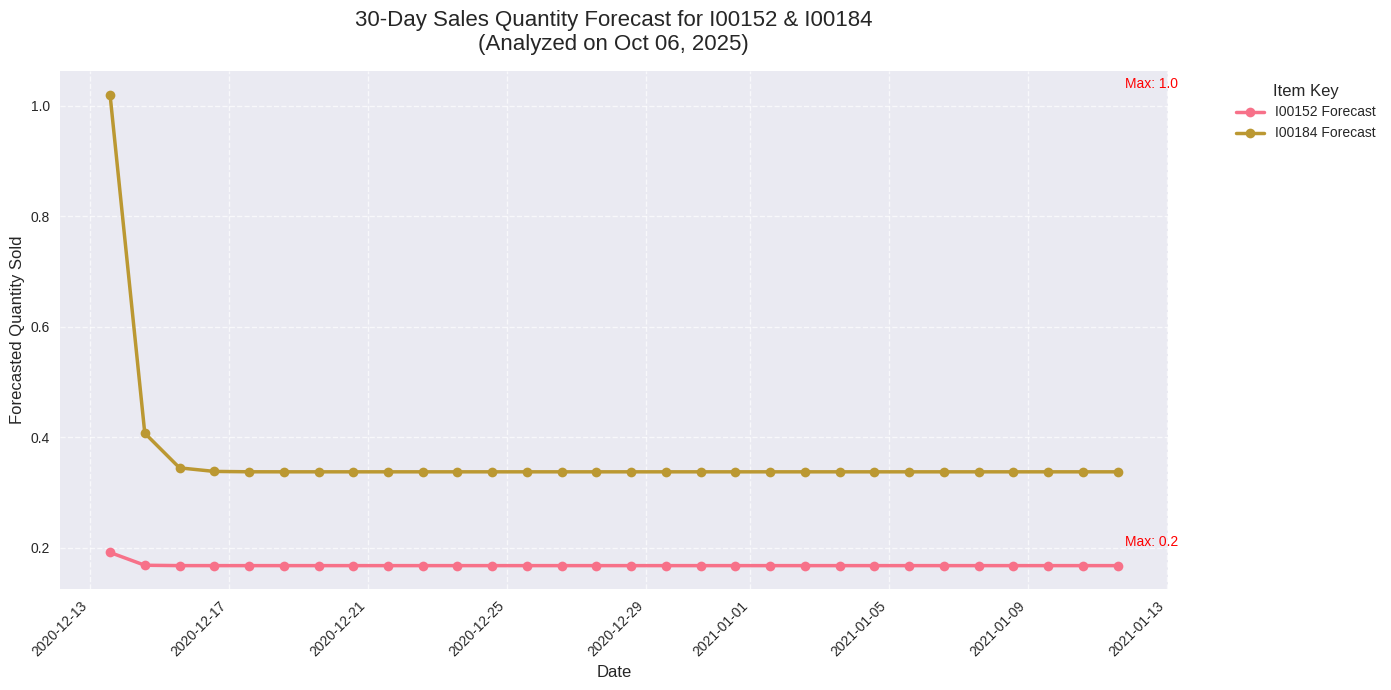


30-Day Forecast for I00152:
                          date  forecasted_quantity
2020-12-13 2020-12-13 13:50:00             0.191710
2020-12-14 2020-12-14 13:50:00             0.168573
2020-12-15 2020-12-15 13:50:00             0.167911
2020-12-16 2020-12-16 13:50:00             0.167892
2020-12-17 2020-12-17 13:50:00             0.167891

30-Day Forecast for I00184:
                          date  forecasted_quantity
2020-12-10 2020-12-13 13:50:00             1.020278
2020-12-11 2020-12-14 13:50:00             0.407578
2020-12-12 2020-12-15 13:50:00             0.344799
2020-12-13 2020-12-16 13:50:00             0.338367
2020-12-14 2020-12-17 13:50:00             0.337708


In [ ]:
#Forecasting sales quantity using arima
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Set aesthetic style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and filter
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Aggregate daily quantity sold
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()

# Forecast for each item
forecasts = {}
end_date = daily_sales['date'].max()
for item in ['I00152', 'I00184']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date').sort_index()['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)

    if len(item_data) > 2:
        try:
            model = ARIMA(item_data, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=30)
            forecast_dates = pd.date_range(end_date + timedelta(days=1), periods=30, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': forecast})
        except Exception as e:
            print(f"ARIMA failed for {item}: {e}. Using last value.")
            last_value = item_data.iloc[-1] if not item_data.empty else 0
            forecast_dates = pd.date_range(end_date + timedelta(days=1), periods=30, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': [last_value] * 30})

# Enhanced plot
plt.figure(figsize=(14, 7), dpi=100)
for item, df in forecasts.items():
    plt.plot(df['date'], df['forecasted_quantity'], label=f'{item} Forecast', linewidth=2.5, marker='o')
    plt.annotate(f'Max: {df["forecasted_quantity"].max():.1f}',
                 xy=(df['date'].iloc[-1], df['forecasted_quantity'].max()),
                 xytext=(5, 5), textcoords='offset points', color='red')
plt.title('30-Day Sales Quantity Forecast for I00152 & I00184\n(Analyzed on Oct 06, 2025)', fontsize=16, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Quantity Sold', fontsize=12)
plt.legend(title='Item Key', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('forecast_quantity.png', bbox_inches='tight')
plt.show()

# Print forecasts
for item, df in forecasts.items():
    print(f"\n30-Day Forecast for {item}:")
    print(df.head(5))

/tmp/ipython-input-916400040.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year'] = filtered_df['date'].dt.year.fillna(0).astype(int)
/tmp/ipython-input-916400040.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['date'].dt.month.fillna(0).astype(int)
/tmp/ipython-input-916400040.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Mean Squared Error: 86.82
R^2 Score: 0.95


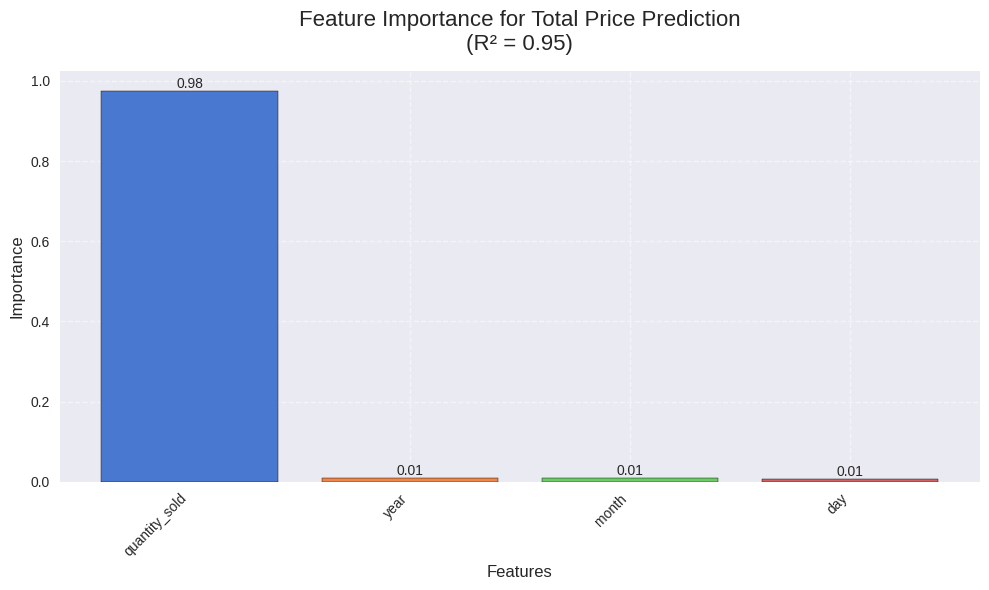

Predicted Total Price for Oct 06, 2025 (5 units): 64.82 BDT


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set aesthetic style
plt.style.use('seaborn-v0_8')
sns.set_palette("muted")

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and filter
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Feature engineering
filtered_df['year'] = filtered_df['date'].dt.year.fillna(0).astype(int)
filtered_df['month'] = filtered_df['date'].dt.month.fillna(0).astype(int)
filtered_df['day'] = filtered_df['date'].dt.day.fillna(0).astype(int)

# Prepare features and target
features = ['quantity_sold', 'year', 'month', 'day']
X = filtered_df[features].fillna(0)
y = filtered_df['total_price'].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Enhanced feature importance plot
plt.figure(figsize=(10, 6), dpi=100)
importance = model.feature_importances_
bars = plt.bar(features, importance, color=sns.color_palette("muted")[:len(features)], edgecolor='black')
plt.title('Feature Importance for Total Price Prediction\n(R² = {:.2f})'.format(r2), fontsize=16, pad=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

# Sample prediction
sample_data = pd.DataFrame({
    'quantity_sold': [5],
    'year': [2025],
    'month': [10],
    'day': [6]
})
pred = model.predict(sample_data)
print(f"Predicted Total Price for Oct 06, 2025 (5 units): {pred[0]:.2f} BDT")

<Figure size 1200x800 with 0 Axes>

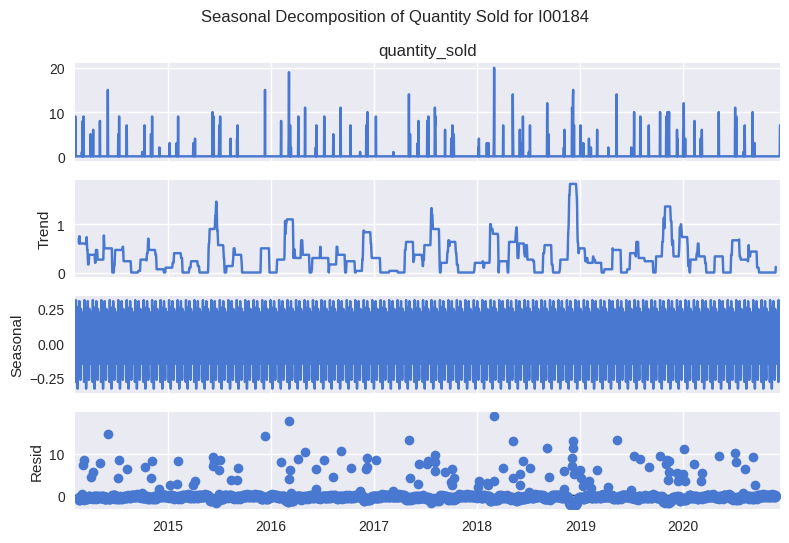

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()
# Perform seasonal decomposition
for item in ['I00184']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date')['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)

    decomposition= seasonal_decompose(item_data, model='additive', period=30)  # Monthly seasonality
    # Plot
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition of Quantity Sold for {item}')
plt.tight_layout()
plt.show()

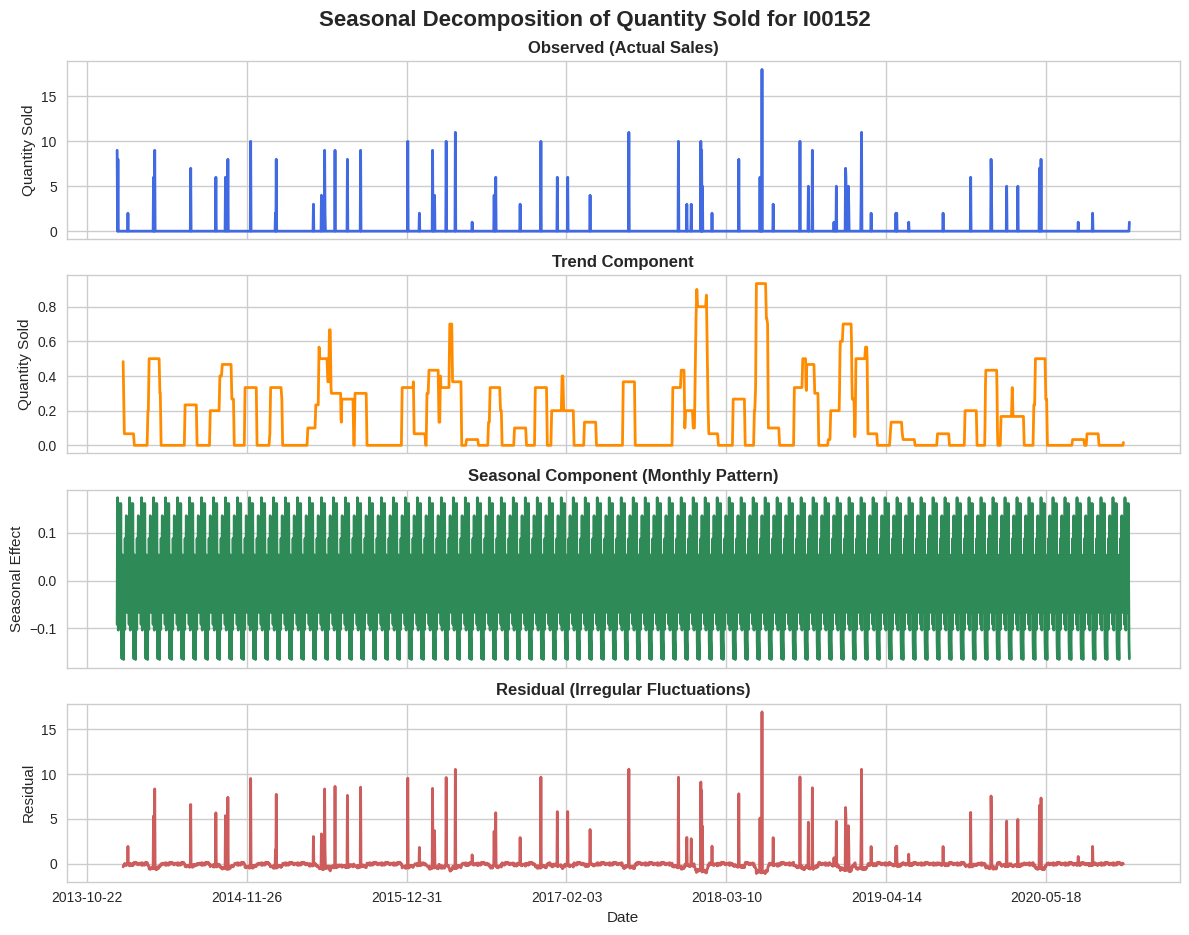

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import MaxNLocator

# Use a clean, modern style
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and prepare
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Filter selected items
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Aggregate by day
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()

# Perform seasonal decomposition for each selected item
for item in ['I00152']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date')['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)

    decomposition = seasonal_decompose(item_data, model='additive', period=30)

    # Create an enhanced visualization
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f'Seasonal Decomposition of Quantity Sold for {item}', fontsize=16, fontweight='bold', y=0.93)

    # Original
    axes[0].plot(decomposition.observed, color='royalblue', linewidth=2)
    axes[0].set_title('Observed (Actual Sales)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Quantity Sold', fontsize=11)
    axes[0].grid(True)

    # Trend
    axes[1].plot(decomposition.trend, color='darkorange', linewidth=2)
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Quantity Sold', fontsize=11)
    axes[1].grid(True)

    # Seasonal
    axes[2].plot(decomposition.seasonal, color='seagreen', linewidth=2)
    axes[2].set_title('Seasonal Component (Monthly Pattern)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Seasonal Effect', fontsize=11)
    axes[2].grid(True)

    # Residual
    axes[3].plot(decomposition.resid, color='indianred', linewidth=2)
    axes[3].set_title('Residual (Irregular Fluctuations)', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Date', fontsize=11)
    axes[3].set_ylabel('Residual', fontsize=11)
    axes[3].grid(True)
    axes[3].xaxis.set_major_locator(MaxNLocator(nbins=8))

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'seasonal_decomposition_{item}.png', dpi=300)
    plt.show()


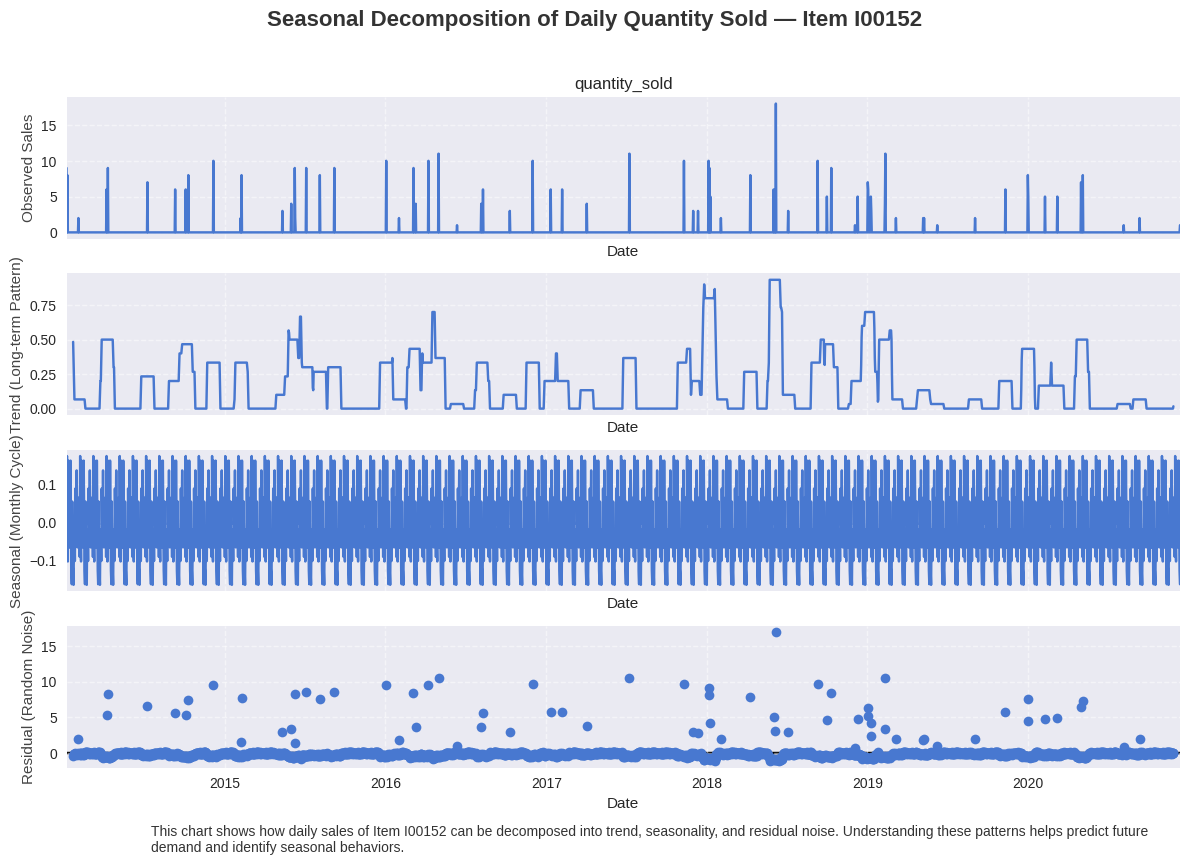

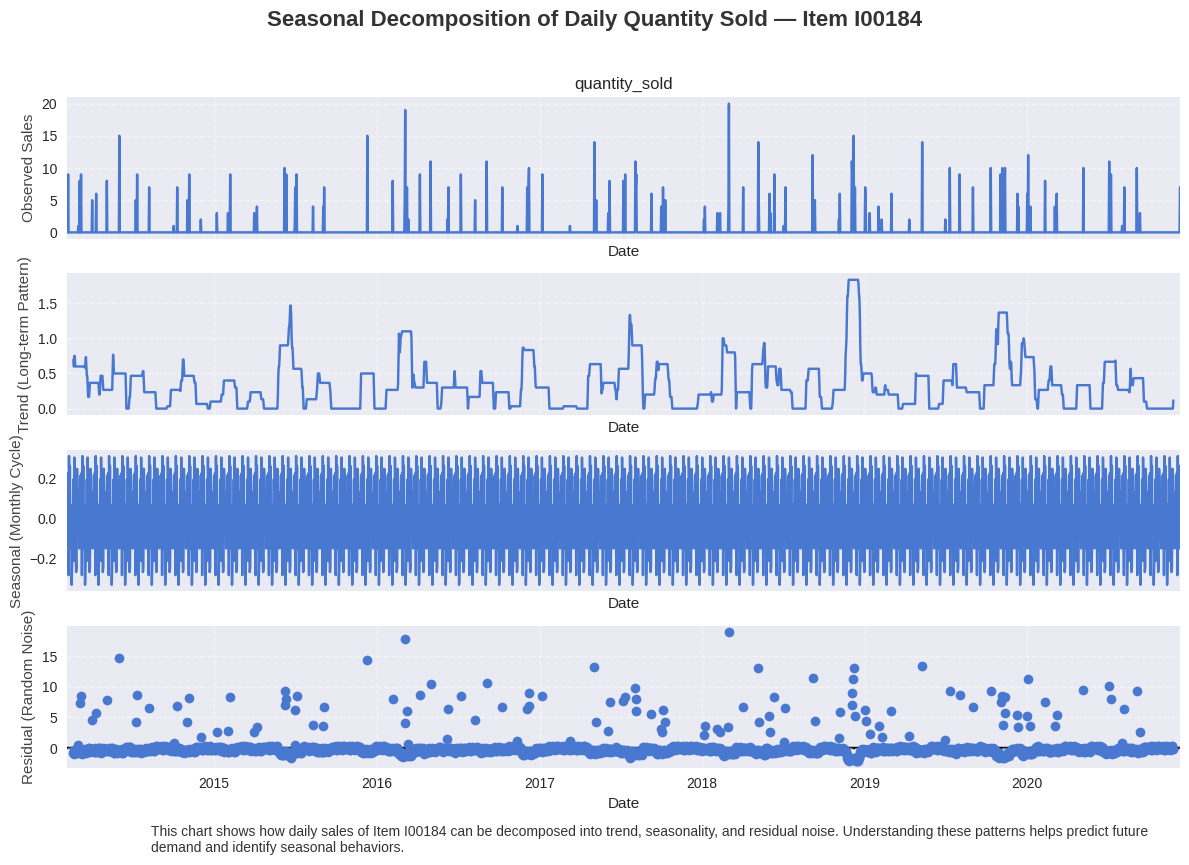

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Optional: better style (modern seaborn look)
plt.style.use('seaborn-v0_8-darkgrid')

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and preprocess
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Filter two key items
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Aggregate daily sales
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()

# Perform seasonal decomposition for each item
for item in ['I00152', 'I00184']:
    item_data = (
        daily_sales[daily_sales['item_key'] == item]
        .set_index('date')['quantity_sold']
        .resample('D')
        .sum()
        .fillna(0)
    )

    # Perform decomposition
    decomposition = seasonal_decompose(item_data, model='additive', period=30)

    # Create a polished figure
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(
        f"Seasonal Decomposition of Daily Quantity Sold — Item {item}",
        fontsize=16,
        fontweight='bold',
        color='#333333',
        y=1.02
    )

    # Customize subplots
    axes = fig.get_axes()
    labels = ['Observed Sales', 'Trend (Long-term Pattern)', 'Seasonal (Monthly Cycle)', 'Residual (Random Noise)']
    for ax, label in zip(axes, labels):
        ax.set_ylabel(label, fontsize=11, color='#444444')
        ax.set_xlabel("Date", fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.5)

    # Add description text below the chart
    plt.figtext(
        0.13, -0.03,
        f"This chart shows how daily sales of Item {item} can be decomposed into trend, seasonality, and residual noise. "
        "Understanding these patterns helps predict future demand and identify seasonal behaviors.",
        wrap=True, fontsize=10, color='#333333'
    )

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 58.8 MB/s eta 0:00:00


Calculated Total Units Based on 30-Day Average: 356


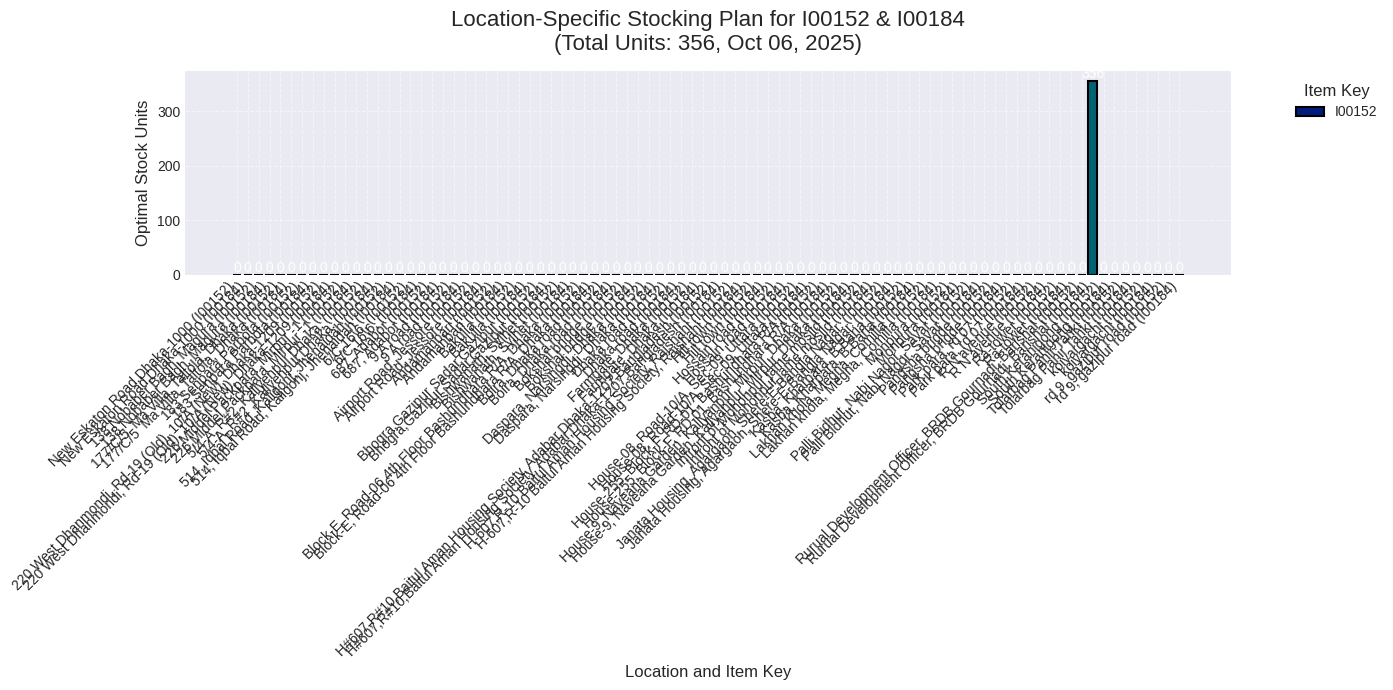

Optimized Location-Specific Stocking Plan:
                             location item_key  optimal_stock
0         New Eskaton Road,Dhaka-1000   I00152            0.0
1         New Eskaton Road,Dhaka-1000   I00184            0.0
2            138,Nobaber Bagh, Magura   I00152            0.0
3            138,Nobaber Bagh, Magura   I00184            0.0
4   177/C/5  Ma Villa, Taltola, Dhaka   I00152            0.0
..                                ...      ...            ...
83               Tolarbag Panir Tanki   I00184            0.0
84                        koiyargachi   I00152            0.0
85                        koiyargachi   I00184            0.0
86                 rd 9, gazipur road   I00152            0.0
87                 rd 9, gazipur road   I00184            0.0

[88 rows x 3 columns]
Total Units Allocated: 356


In [ ]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("dark")

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
store_df = pd.read_excel('case-study-data.xlsx', sheet_name='Store_dim')

# Merge and filter
merged_df = fact_df.merge(store_df, on='store_key', how='left')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Aggregate sales by location and item
loc_item_sales = filtered_df.groupby(['location', 'item_key'])['quantity_sold'].sum().reset_index()
total_sales = loc_item_sales['quantity_sold'].sum() if not loc_item_sales.empty else 1

# Calculate dynamic total units
daily_avg = filtered_df.groupby('item_key')['quantity_sold'].mean().sum()
total_units = int(daily_avg * 30)
print(f"Calculated Total Units Based on 30-Day Average: {total_units}")

# Optimize stocking
model = pulp.LpProblem("Stocking_Optimization", pulp.LpMaximize)
locations = loc_item_sales['location'].unique()
stock = pulp.LpVariable.dicts("Stock", [(loc, item) for loc in locations for item in ['I00152', 'I00184']],
                              lowBound=0, cat='Integer')

# Objective: Maximize total quantity sold
objective_terms = []
for loc in locations:
    for item in ['I00152', 'I00184']:
        sales_row = loc_item_sales[(loc_item_sales['location'] == loc) & (loc_item_sales['item_key'] == item)]
        if not sales_row.empty:
            weight = sales_row['quantity_sold'].iloc[0] / total_sales
            objective_terms.append(stock[(loc, item)] * weight)
model += pulp.lpSum(objective_terms)

# Constraint: Total units ≤ calculated total
model += pulp.lpSum([stock[(loc, item)] for loc in locations for item in ['I00152', 'I00184']]) <= total_units

# Solve
model.solve()
optimized_stock = {(loc, item): stock[(loc, item)].value() for loc in locations for item in ['I00152', 'I00184']}
stock_df = pd.DataFrame([(loc, item, val) for (loc, item), val in optimized_stock.items()],
                        columns=['location', 'item_key', 'optimal_stock'])

# Enhanced plot
plt.figure(figsize=(14, 7), dpi=100)
bars = plt.bar([f'{loc} ({item})' for loc, item in zip(stock_df['location'], stock_df['item_key'])],
               stock_df['optimal_stock'], color=sns.color_palette("dark")[:len(stock_df)], edgecolor='black', linewidth=1.5)
plt.title(f'Location-Specific Stocking Plan for I00152 & I00184\n(Total Units: {total_units}, Oct 06, 2025)',
          fontsize=16, pad=15)
plt.xlabel('Location and Item Key', fontsize=12)
plt.ylabel('Optimal Stock Units', fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, color='white')
plt.legend(['I00152', 'I00184'], title='Item Key', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('stocking_plan.png', bbox_inches='tight')
plt.show()

# Print
print("Optimized Location-Specific Stocking Plan:")
print(stock_df)
print(f"Total Units Allocated: {sum(stock_df['optimal_stock']):.0f}")

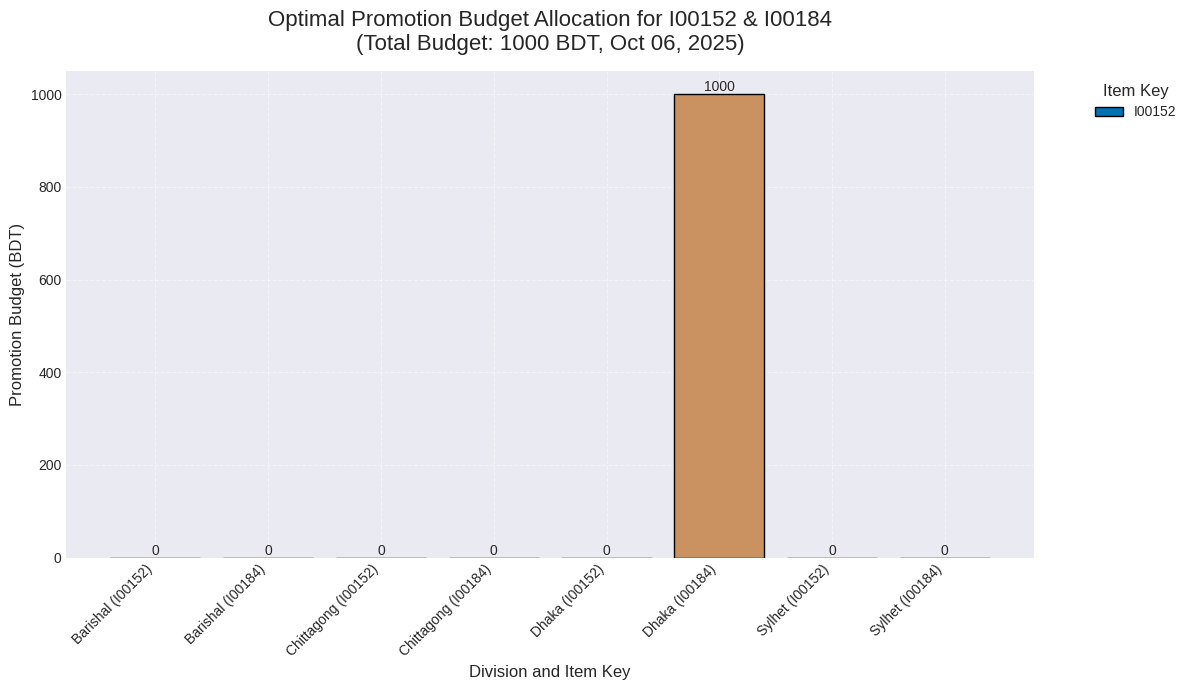

Optimized Promotion Budget Allocation:
     division item_key  promo_budget  unique_customers
0    Barishal   I00152  0.000000e+00                 4
1    Barishal   I00184  0.000000e+00                14
2  Chittagong   I00152  0.000000e+00                22
3  Chittagong   I00184  0.000000e+00                26
4       Dhaka   I00152  1.023181e-12               160
5       Dhaka   I00184  1.000000e+03               280
6      Sylhet   I00152  0.000000e+00                 7
7      Sylhet   I00184  0.000000e+00                13
Total Budget Used: 1000.00 BDT


In [ ]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
customer_df = pd.read_excel('case-study-data.xlsx', sheet_name='Customer_dim')

# Merge and filter
merged_df = fact_df.merge(customer_df, on='customer_key', how='left')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

# Aggregate purchase frequency by customer division
customer_freq = filtered_df.groupby(['division', 'item_key'])['customer_key'].nunique().reset_index()
customer_freq.columns = ['division', 'item_key', 'unique_customers']

# Optimize promotion budget
budget = 1000
model = pulp.LpProblem("Promotion_Optimization", pulp.LpMaximize)
divisions = customer_freq['division'].unique()
promo = pulp.LpVariable.dicts("Promo", [(div, item) for div in divisions for item in ['I00152', 'I00184']],
                              lowBound=0, upBound=budget, cat='Continuous')

# Objective: Maximize reach
model += pulp.lpSum([promo[(div, item)] * customer_freq[(customer_freq['division'] == div) &
                                                        (customer_freq['item_key'] == item)]['unique_customers'].iloc[0]
                     for div in divisions for item in ['I00152', 'I00184']])

# Constraint: Total budget ≤ 1000 BDT
model += pulp.lpSum([promo[(div, item)] for div in divisions for item in ['I00152', 'I00184']]) <= budget

# Solve
model.solve()
optimized_promo = {(div, item): promo[(div, item)].value() for div in divisions for item in ['I00152', 'I00184']}
promo_df = pd.DataFrame([(div, item, val) for (div, item), val in optimized_promo.items()],
                        columns=['division', 'item_key', 'promo_budget'])
promo_df['unique_customers'] = promo_df.apply(
    lambda row: customer_freq[(customer_freq['division'] == row['division']) &
                             (customer_freq['item_key'] == row['item_key'])]['unique_customers'].iloc[0], axis=1)

# Enhanced plot
plt.figure(figsize=(12, 7), dpi=100)
bars = plt.bar([f'{div} ({item})' for div, item in zip(promo_df['division'], promo_df['item_key'])],
               promo_df['promo_budget'], color=sns.color_palette("colorblind")[:len(promo_df)], edgecolor='black')
plt.title('Optimal Promotion Budget Allocation for I00152 & I00184\n(Total Budget: 1000 BDT, Oct 06, 2025)',
          fontsize=16, pad=15)
plt.xlabel('Division and Item Key', fontsize=12)
plt.ylabel('Promotion Budget (BDT)', fontsize=12)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
plt.legend(['I00152', 'I00184'], title='Item Key', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('promotion_budget.png', bbox_inches='tight')
plt.show()

# Print
print("Optimized Promotion Budget Allocation:")
print(promo_df)
print(f"Total Budget Used: {sum(promo_df['promo_budget']):.2f} BDT")

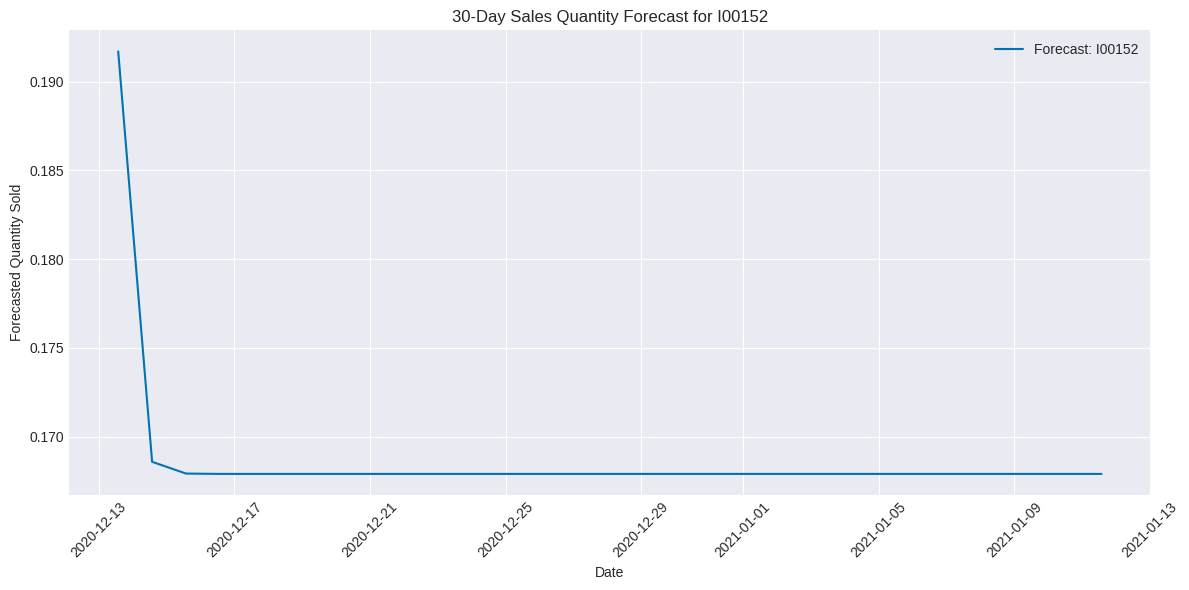

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152'])]
# Aggregate daily quantity sold
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()
# Forecast for each item
forecasts = {}
end_date = daily_sales['date'].max()
for item in ['I00152']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date').sort_index()['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)
    if len(item_data) > 2:
        try:
            model = ARIMA(item_data, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=30)
            forecast_dates = pd.date_range(end_date + timedelta(days=1), periods=30, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': forecast})
        except Exception as e:
            print(f"ARIMA failed for {item}: {e}. Using last value.")
            last_value = item_data.iloc[-1] if not item_data.empty else 0
            forecast_dates = pd.date_range(end_date + timedelta(days=1), periods=30, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': [last_value] * 30})
            # Plot forecasts
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
for item, df in forecasts.items():
    ax.plot(df['date'], df['forecasted_quantity'], label=f'Forecast: {item}')
ax.set_title('30-Day Sales Quantity Forecast for I00152')
ax.set_xlabel('Date')
ax.set_ylabel('Forecasted Quantity Sold')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: Cannot index by location index with a non-integer key

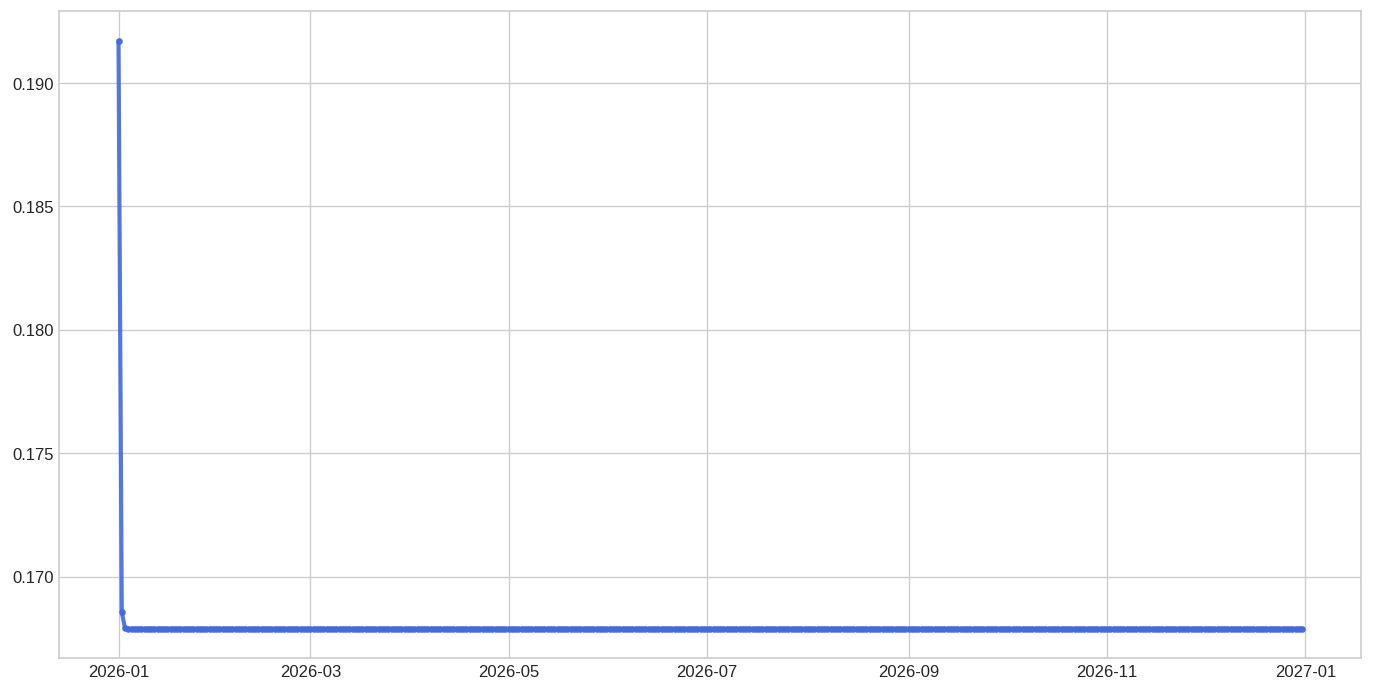

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

# ✅ Set modern style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 📂 Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# 🧩 Merge and prepare
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'] == 'I00152']

# 📊 Aggregate daily quantity sold
daily_sales = filtered_df.groupby('date')['quantity_sold'].sum().reset_index()

# ⚙️ Forecast setup
forecasts = {}
days_in_2026 = 365
start_2026 = pd.to_datetime('2026-01-01')

# 🔮 Forecast using ARIMA
item = 'I00152'
item_data = daily_sales.set_index('date').sort_index()['quantity_sold']
item_data = item_data.resample('D').sum().fillna(0)

if len(item_data) > 2:
    try:
        model = ARIMA(item_data, order=(1, 1, 1))
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=days_in_2026)
        forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
        forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': forecast})

    except Exception as e:
        print(f"ARIMA failed for {item}: {e}. Using last known value.")
        last_value = item_data.iloc[-1] if not item_data.empty else 0
        forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
        forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': [last_value] * days_in_2026})

# 🎨 Enhanced Visualization
plt.figure(figsize=(14, 7), dpi=120)
for item, df in forecasts.items():
    plt.plot(df['date'], df['forecasted_quantity'],
             label=f'Forecast: {item}',
             linewidth=2.5, color='royalblue', marker='o', markersize=3, alpha=0.9)

    # Annotate maximum forecasted value
    max_idx = df['forecasted_quantity'].idxmax()
    plt.annotate(f"Max: {df['forecasted_quantity'].max():.1f}\n({df['date'].iloc[max_idx].strftime('%b %d')})",
                 xy=(df['date'].iloc[max_idx], df['forecasted_quantity'].max()),
                 xytext=(30, 10), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                 fontsize=10, color='darkred')

# 🏷️ Labels and formatting
plt.title('2026 Sales Quantity Forecast for I00152', fontsize=16, fontweight='bold', pad=15)
plt.suptitle(f"Generated on {datetime.now().strftime('%b %d, %Y, %I:%M %p')}", fontsize=10, y=0.93, color='gray')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Quantity Sold', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Item Key', fontsize=10, title_fontsize=11, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.xticks(pd.date_range(start_2026, periods=12, freq='M'),
           [d.strftime('%b %Y') for d in pd.date_range(start_2026, periods=12, freq='M')],
           rotation=45, ha='right')

plt.tight_layout()
plt.savefig('forecast_2026_I00152.png', bbox_inches='tight')
plt.show()

# 📋 Print forecast summary
for item, df in forecasts.items():
    print(f"\n=== 2026 Forecast Summary for {item} ===")
    print(f"Average Forecasted Quantity: {df['forecasted_quantity'].mean():.2f} units/day")
    print(f"Maximum Forecasted Quantity: {df['forecasted_quantity'].max():.2f} units on {df['date'].iloc[df['forecasted_quantity'].idxmax()].date()}")
    print("\nSample Forecast Data:")
    print(df.head(3).to_string(index=False))
    print("...")
    print(df.tail(3).to_string(index=False))


/tmp/ipython-input-3737281184.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start_2026, periods=13, freq='M').tolist(),
/tmp/ipython-input-3737281184.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [d.strftime('%b %Y') for d in pd.date_range(start_2026, periods=13, freq='M')],


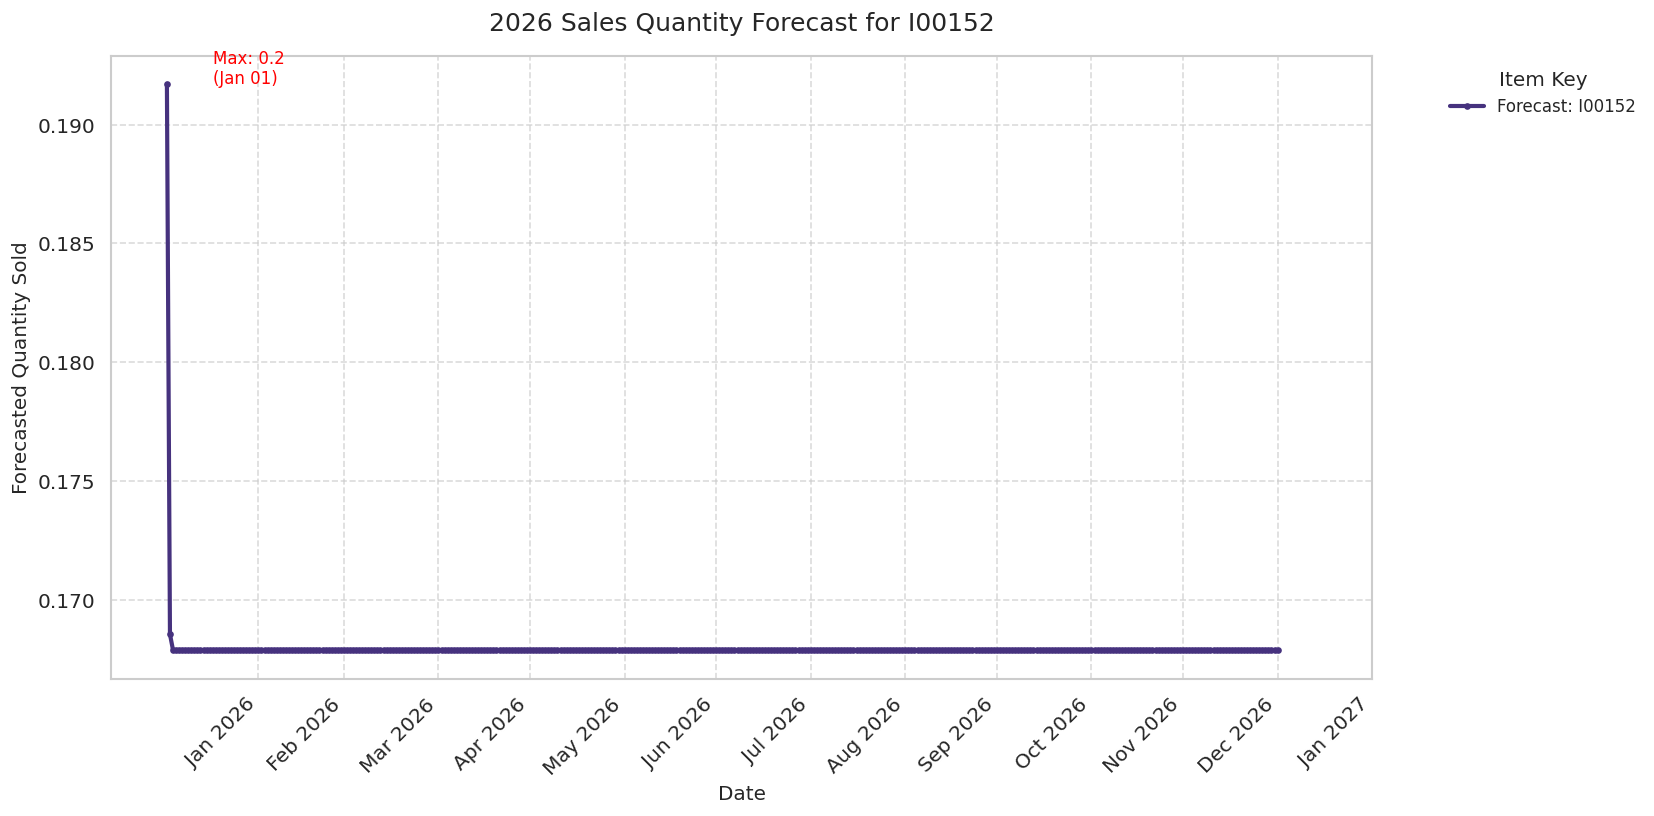


2026 Forecast Summary for I00152:
Mean Forecasted Quantity: 0.17 units/day
Max Forecasted Quantity: 0.19 units on 2026-01-01

Sample Forecast (First 5 days of 2026):
                 date  forecasted_quantity
2020-12-13 2026-01-01             0.191710
2020-12-14 2026-01-02             0.168573
2020-12-15 2026-01-03             0.167911
2020-12-16 2026-01-04             0.167892
2020-12-17 2026-01-05             0.167891


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Set visualization style
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and filter for I00152
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152'])]

# Aggregate daily quantity sold
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()

# Forecast for I00152 for the year 2026
forecasts = {}
end_date = daily_sales['date'].max()  # Latest date in the dataset
start_2026 = pd.to_datetime('2026-01-01')  # Start of 2026
days_in_2026 = 365  # Full year forecast

for item in ['I00152']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date').sort_index()['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)

    if len(item_data) > 2:
        try:
            model = ARIMA(item_data, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=days_in_2026)
            forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': forecast})
        except Exception as e:
            print(f"ARIMA failed for {item}: {e}. Using last value.")
            last_value = item_data.iloc[-1] if not item_data.empty else 0
            forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
            forecasts[item] = pd.DataFrame({
                'date': forecast_dates,
                'forecasted_quantity': [last_value] * days_in_2026
            })

# Plot the 2026 forecast
plt.figure(figsize=(14, 7), dpi=120)
for item, df in forecasts.items():
    plt.plot(df['date'], df['forecasted_quantity'], label=f'Forecast: {item}', linewidth=2.5, marker='o', markersize=3)

    # Annotate maximum forecasted value
    max_idx = df['forecasted_quantity'].idxmax()
    max_date = df.loc[max_idx, 'date']
    max_value = df.loc[max_idx, 'forecasted_quantity']
    plt.annotate(f'Max: {max_value:.1f}\n({max_date.strftime("%b %d")})',
                 xy=(max_date, max_value),
                 xytext=(max_date + timedelta(days=15), max_value),
                 arrowprops=dict(facecolor='red', arrowstyle='->'),
                 fontsize=10, color='red')

plt.title('2026 Sales Quantity Forecast for I00152', fontsize=15, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Quantity Sold', fontsize=12)
plt.legend(title='Item Key', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(pd.date_range(start_2026, periods=13, freq='M').tolist(),
           [d.strftime('%b %Y') for d in pd.date_range(start_2026, periods=13, freq='M')],
           rotation=45, ha='right')
plt.tight_layout()
plt.savefig('forecast_2026_I00152.png', bbox_inches='tight')
plt.show()

# Print forecast summary
for item, df in forecasts.items():
    print(f"\n2026 Forecast Summary for {item}:")
    print(f"Mean Forecasted Quantity: {df['forecasted_quantity'].mean():.2f} units/day")
    print(f"Max Forecasted Quantity: {df['forecasted_quantity'].max():.2f} units on {df.loc[df['forecasted_quantity'].idxmax(), 'date'].date()}")
    print("\nSample Forecast (First 5 days of 2026):")
    print(df.head(5))


/tmp/ipython-input-2943222972.py:68: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start_2026, periods=13, freq='M').tolist(),
/tmp/ipython-input-2943222972.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [d.strftime('%b %Y') for d in pd.date_range(start_2026, periods=13, freq='M')],


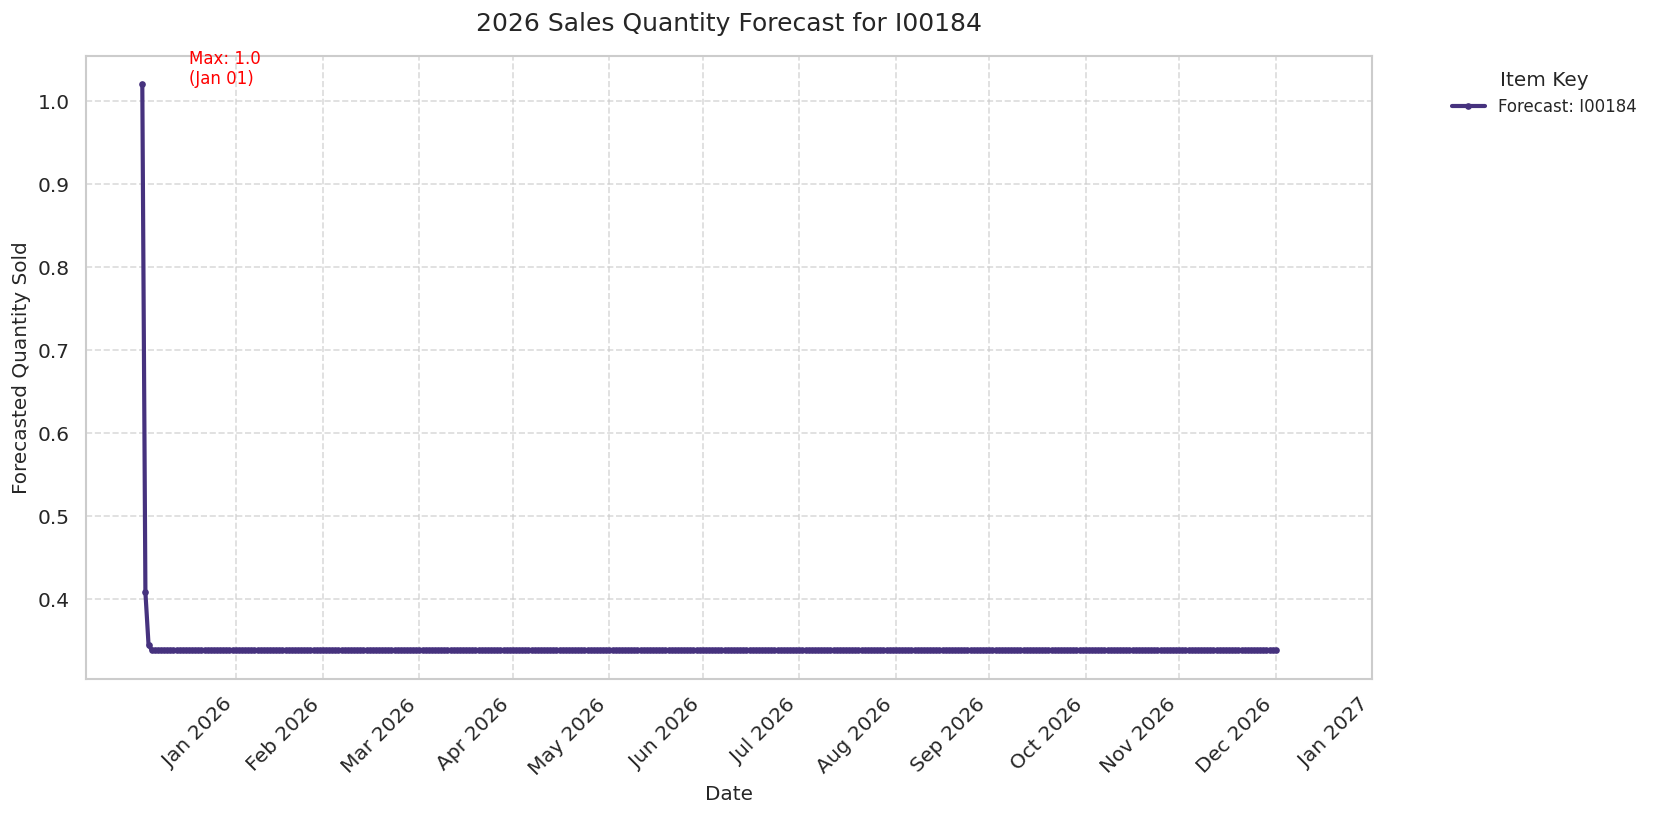


2026 Forecast Summary for I00184:
Mean Forecasted Quantity: 0.34 units/day
Max Forecasted Quantity: 1.02 units on 2026-01-01

Sample Forecast (First 5 days of 2026):
                 date  forecasted_quantity
2020-12-10 2026-01-01             1.020278
2020-12-11 2026-01-02             0.407578
2020-12-12 2026-01-03             0.344799
2020-12-13 2026-01-04             0.338367
2020-12-14 2026-01-05             0.337708


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

# Set visualization style
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

# Load data
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')

# Merge and filter for I00184
merged_df = fact_df.merge(time_df, on='time_key', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
filtered_df = merged_df[merged_df['item_key'].isin(['I00184'])]

# Aggregate daily quantity sold
daily_sales = filtered_df.groupby(['item_key', 'date'])['quantity_sold'].sum().reset_index()

# Forecast for I00152 for the year 2026
forecasts = {}
end_date = daily_sales['date'].max()  # Latest date in the dataset
start_2026 = pd.to_datetime('2026-01-01')  # Start of 2026
days_in_2026 = 365  # Full year forecast

for item in ['I00184']:
    item_data = daily_sales[daily_sales['item_key'] == item].set_index('date').sort_index()['quantity_sold']
    item_data = item_data.resample('D').sum().fillna(0)

    if len(item_data) > 2:
        try:
            model = ARIMA(item_data, order=(1, 1, 1))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=days_in_2026)
            forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
            forecasts[item] = pd.DataFrame({'date': forecast_dates, 'forecasted_quantity': forecast})
        except Exception as e:
            print(f"ARIMA failed for {item}: {e}. Using last value.")
            last_value = item_data.iloc[-1] if not item_data.empty else 0
            forecast_dates = pd.date_range(start_2026, periods=days_in_2026, freq='D')
            forecasts[item] = pd.DataFrame({
                'date': forecast_dates,
                'forecasted_quantity': [last_value] * days_in_2026
            })

# Plot the 2026 forecast
plt.figure(figsize=(14, 7), dpi=120)
for item, df in forecasts.items():
    plt.plot(df['date'], df['forecasted_quantity'], label=f'Forecast: {item}', linewidth=2.5, marker='o', markersize=3)

    # Annotate maximum forecasted value
    max_idx = df['forecasted_quantity'].idxmax()
    max_date = df.loc[max_idx, 'date']
    max_value = df.loc[max_idx, 'forecasted_quantity']
    plt.annotate(f'Max: {max_value:.1f}\n({max_date.strftime("%b %d")})',
                 xy=(max_date, max_value),
                 xytext=(max_date + timedelta(days=15), max_value),
                 arrowprops=dict(facecolor='red', arrowstyle='->'),
                 fontsize=10, color='red')

plt.title('2026 Sales Quantity Forecast for I00184', fontsize=15, pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Forecasted Quantity Sold', fontsize=12)
plt.legend(title='Item Key', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(pd.date_range(start_2026, periods=13, freq='M').tolist(),
           [d.strftime('%b %Y') for d in pd.date_range(start_2026, periods=13, freq='M')],
           rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print forecast summary
for item, df in forecasts.items():
    print(f"\n2026 Forecast Summary for {item}:")
    print(f"Mean Forecasted Quantity: {df['forecasted_quantity'].mean():.2f} units/day")
    print(f"Max Forecasted Quantity: {df['forecasted_quantity'].max():.2f} units on {df.loc[df['forecasted_quantity'].idxmax(), 'date'].date()}")
    print("\nSample Forecast (First 5 days of 2026):")
    print(df.head(5))


#Store S0035

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta

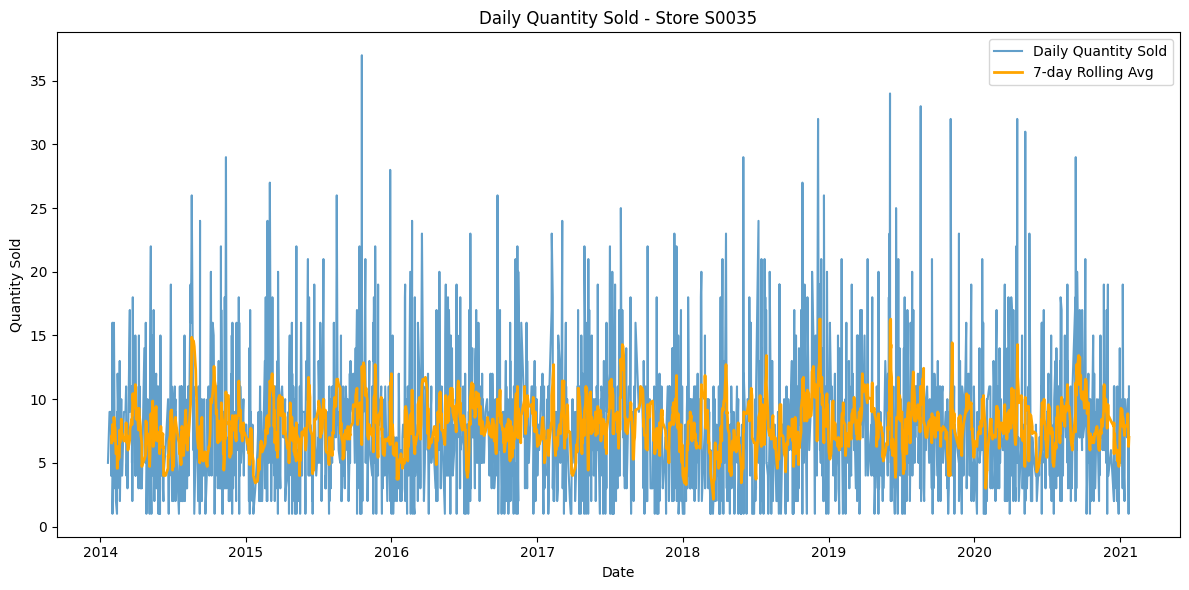

/tmp/ipython-input-1639157202.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekday_avg, x="weekday", y="quantity_sold", palette="viridis")


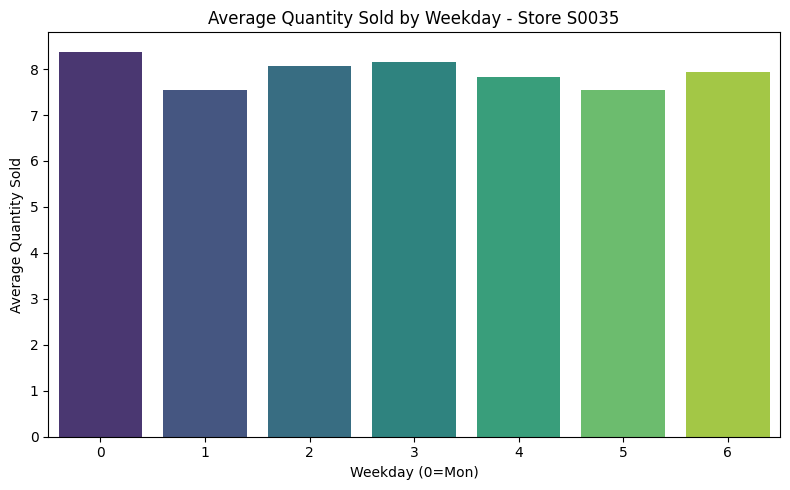

/tmp/ipython-input-1639157202.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items, x="item_key", y="quantity_sold", palette="rocket")


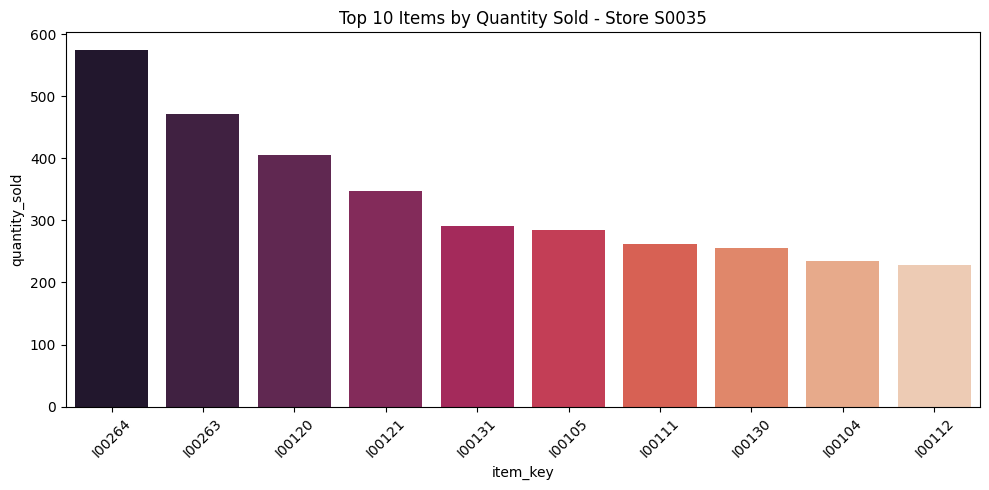


Model Performance - Store S0035
Test RMSE: 3.425
Test R2: 0.571


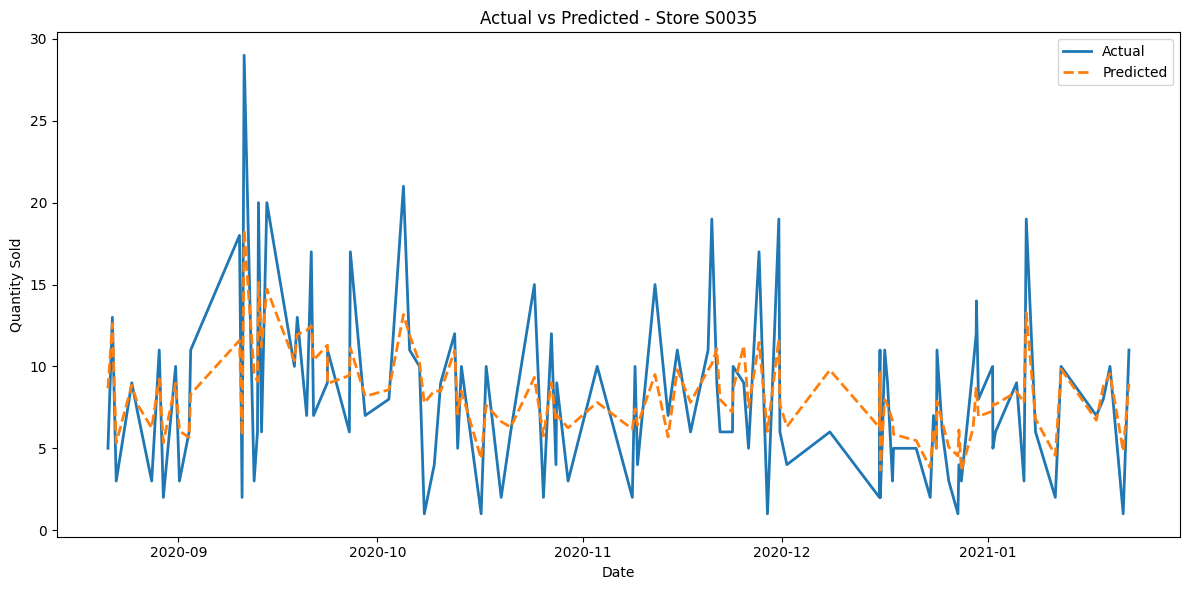

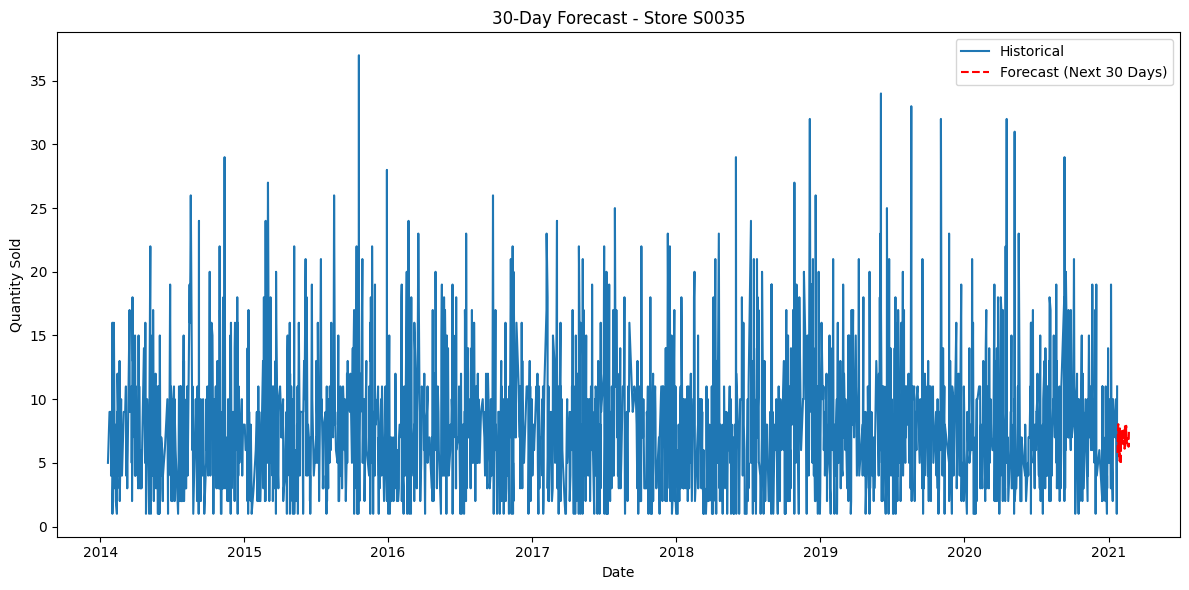


==== AUTO INSIGHTS ====
Total records analyzed: 2869
Mean daily quantity_sold (all time): 7.92
Recent 30-day mean: 6.87
Weekday with highest avg: 0
Forecast total (next 30 days): 205.41

Forecast saved as 'forecast_S0035.csv'


In [ ]:
# ================================================
# Store Analysis (Descriptive + Predictive)
# For store S0035
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta

# ---------- 1. Load Data ----------
file_path = "case-study-data.xlsx"  # Change path if needed
fact = pd.read_excel(file_path, sheet_name="Fact_table")
time_dim = pd.read_excel(file_path, sheet_name="Time_dim")
store_dim = pd.read_excel(file_path, sheet_name="Store_dim")

# ---------- 2. Filter Store ----------
store_id = "S0035"
store_df = fact[fact["store_key"] == store_id].copy()

# Merge with Time_dim to get actual dates
store_df = store_df.merge(time_dim[["time_key", "date"]], on="time_key", how="left")

# ---------- 3. Date Parsing Fix ----------
# Handle formats like "28-07-2018 01:10"
store_df["date"] = pd.to_datetime(store_df["date"], dayfirst=True, errors="coerce")
store_df = store_df.dropna(subset=["date"])  # Drop invalid dates

# ---------- 4. Prepare Daily Sales ----------
daily_sales = (
    store_df.groupby("date", as_index=False)["quantity_sold"]
    .sum()
    .sort_values("date")
)

# ---------- 5. Descriptive Analysis ----------

# Daily Quantity Trend
plt.figure(figsize=(12,6))
plt.plot(daily_sales["date"], daily_sales["quantity_sold"], label="Daily Quantity Sold", alpha=0.7)
plt.plot(daily_sales["date"], daily_sales["quantity_sold"].rolling(7).mean(),
         label="7-day Rolling Avg", linewidth=2, color="orange")
plt.title(f"Daily Quantity Sold - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.tight_layout()
plt.show()

# Weekday Pattern
daily_sales["weekday"] = daily_sales["date"].dt.dayofweek
weekday_avg = daily_sales.groupby("weekday")["quantity_sold"].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=weekday_avg, x="weekday", y="quantity_sold", palette="viridis")
plt.title(f"Average Quantity Sold by Weekday - Store {store_id}")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Average Quantity Sold")
plt.tight_layout()
plt.show()

# Top 10 Items by Quantity Sold
top_items = store_df.groupby("item_key")["quantity_sold"].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=top_items, x="item_key", y="quantity_sold", palette="rocket")
plt.title(f"Top 10 Items by Quantity Sold - Store {store_id}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- 6. Predictive Analysis (Random Forest) ----------

# Sort and create lag features
daily_sales = daily_sales.sort_values("date").reset_index(drop=True)
ts = daily_sales.set_index("date")["quantity_sold"]

df = pd.DataFrame(ts)
for lag in range(1, 8):
    df[f"lag_{lag}"] = df["quantity_sold"].shift(lag)
df["rolling_7"] = df["quantity_sold"].rolling(7).mean()
df = df.dropna()

# Split Train/Test
train_size = int(len(df) * 0.95)
train, test = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train.drop("quantity_sold", axis=1), train["quantity_sold"]
X_test, y_test = test.drop("quantity_sold", axis=1), test["quantity_sold"]

# Train Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print(f"\nModel Performance - Store {store_id}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {r2:.3f}")

# Actual vs Predicted Plot
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test, label="Actual", linewidth=2)
plt.plot(test.index, preds, label="Predicted", linewidth=2, linestyle="--")
plt.title(f"Actual vs Predicted - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 7. Forecast Next 30 Days ----------
future_days = 30
future_df = df.copy()

for i in range(future_days):
    last_row = future_df.iloc[-1:].copy()
    new_date = last_row.index[0] + timedelta(days=1)

    # Create lag features
    new_row = pd.DataFrame({
        f"lag_{j}": [last_row["quantity_sold"].values[0] if j == 1 else last_row[f"lag_{j-1}"].values[0]]
        for j in range(1, 8)
    })
    new_row["rolling_7"] = future_df["quantity_sold"].tail(7).mean()
    new_row.index = [new_date]

    pred_val = model.predict(new_row)[0]
    new_row["quantity_sold"] = pred_val
    future_df = pd.concat([future_df, new_row])

forecast_df = future_df.tail(future_days)[["quantity_sold"]].rename(columns={"quantity_sold": "forecasted_quantity"})

# Plot Historical + Forecast
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, label="Historical")
plt.plot(forecast_df.index, forecast_df["forecasted_quantity"],
         label="Forecast (Next 30 Days)", linestyle="--", color="red")
plt.title(f"30-Day Forecast - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 8. Auto Insights ----------
print("\n==== AUTO INSIGHTS ====")
print(f"Total records analyzed: {len(store_df)}")
print(f"Mean daily quantity_sold (all time): {ts.mean():.2f}")
print(f"Recent 30-day mean: {ts.tail(30).mean():.2f}")
print(f"Weekday with highest avg: {weekday_avg.loc[weekday_avg['quantity_sold'].idxmax(),'weekday']}")
print(f"Forecast total (next 30 days): {forecast_df['forecasted_quantity'].sum():.2f}")

# ---------- 9. Save Forecast ----------
forecast_df.to_csv(f"forecast_{store_id}.csv")
print(f"\nForecast saved as 'forecast_{store_id}.csv'")


In [ ]:
import pandas as pd

In [ ]:
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
trans_df = pd.read_excel('case-study-data.xlsx', sheet_name='Trans_dim')
item_df = pd.read_excel('case-study-data.xlsx', sheet_name='Item_dim')
customer_df = pd.read_excel('case-study-data.xlsx', sheet_name='Customer_dim')
time_df = pd.read_excel('case-study-data.xlsx', sheet_name='Time_dim')
store_df = pd.read_excel('case-study-data.xlsx', sheet_name='Store_dim')

In [ ]:
merged_df = fact_df.merge(trans_df, on='payment_key', how='left')
merged_df = merged_df.merge(item_df, on='item_key', how='left')
merged_df = merged_df.merge(customer_df, on='customer_key', how='left')
merged_df = merged_df.merge(time_df, on='time_key', how='left')
merged_df = merged_df.merge(store_df, on='store_key', how='left')

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

In [ ]:
# Top items by quantity sold
item_quantity = merged_df.groupby('item_name')['quantity_sold'].sum().sort_values(ascending=False).head(10)
print("Top 10 Items by Quantity Sold:")
print(item_quantity)

Top 10 Items by Quantity Sold:
item_name
Tylenol Extra Strength 2 pill packets    18163
Advil 2 pill packets                     17766
Stirrers Coffee Stirs 7inch              14060
K Cups - Green Tea                       13864
Hefty Supreme Foam Bowls 12oz             9221
Paper Bowls 20 oz Ultra Strong            8751
K Cups Hot Cocoa                          8030
Njoy Creamer Canister 16 oz               8008
Swiss Miss Hot Cocoa Mix 1 oz             8002
Njoy Creamer Packs                        7672
Name: quantity_sold, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

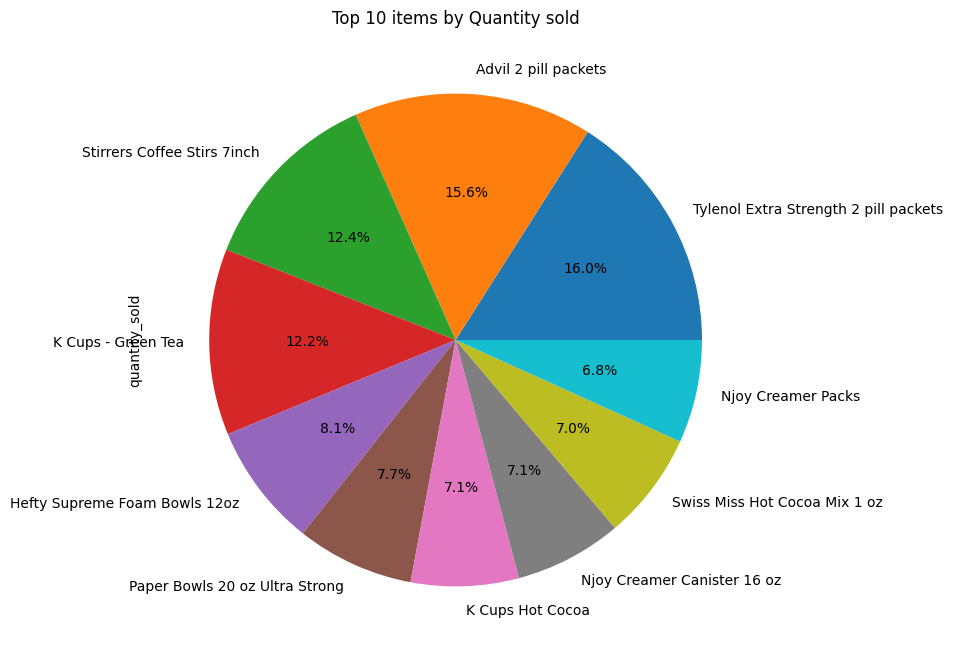

In [ ]:
item_quantity.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Top 10 items by Quantity sold')
plt.show()

In [ ]:
# Item type distribution
item_type_dist = merged_df['item_type'].value_counts()
print("\nItem Type Distribution:")
print(item_type_dist)


Item Type Distribution:
item_type
Beverage Water                 6159
Medicine                       6022
Food - Healthy                 5429
Food - Chocolate               4511
a. Beverage Sparkling Water    4476
Food - Chips                   4227
Gum - Mints                    4129
Beverage - Juice               3958
Dishware - Plates              3832
Dishware - Cups Hot            3713
Food - Nuts                    3696
Food - Sweets                  3608
Kitchen Supplies               3548
Beverage - Energy/Protein      3539
Food - Snacks                  3330
a. Beverage - Soda             3320
Dishware - Bowls               2982
Coffee Cream                   2762
Coffee Ground                  2755
Coffee Hot Cocoa               2695
Coffee Sweetener               2689
Dishware - Utensils            2649
Coffee Creamer                 2607
Dishware - Cups Cold           2417
Coffee Stirrers                2377
Beverage - Iced Tea            2343
Coffee K-Cups Tea            

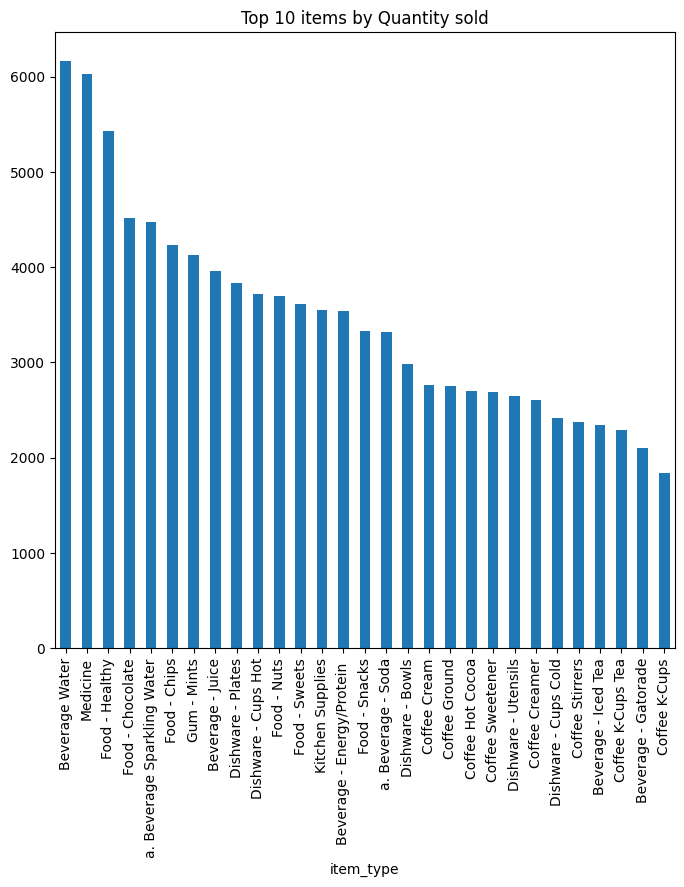

In [ ]:
item_type_dist.plot(kind='bar', figsize=(8, 8))
plt.title('Top 10 items by Quantity sold')
plt.show()

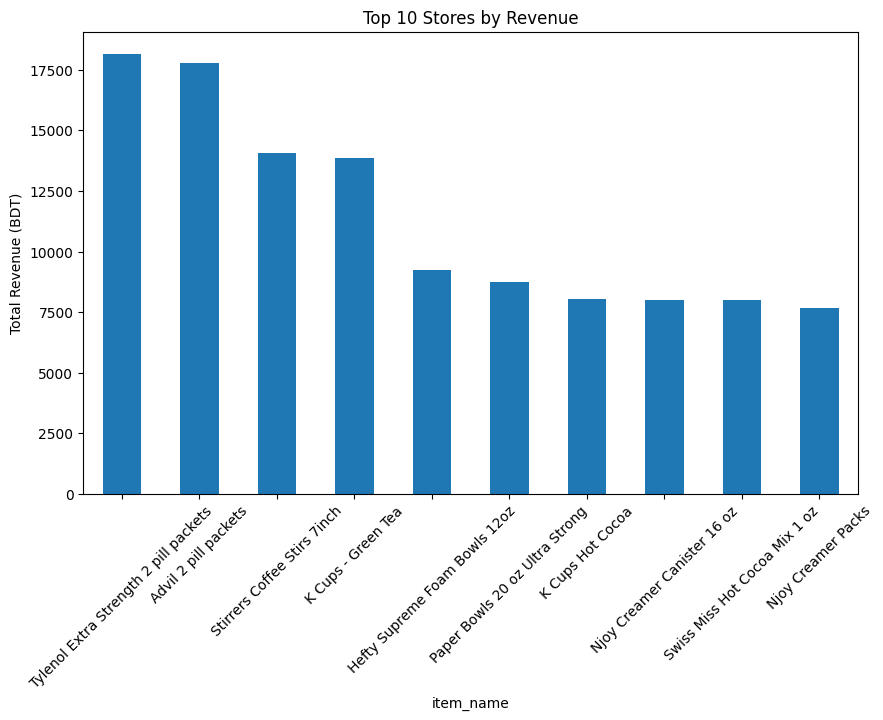

In [ ]:

item_quantity.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Stores by Revenue')
plt.ylabel('Total Revenue (BDT)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
store_revenue = merged_df.groupby('location')['total_price'].sum().sort_values(ascending=False).head(10)
print("Top 10 Stores by Revenue:")
print(store_revenue)

Top 10 Stores by Revenue:
location
Hossain road                                               298491.25
183 Senpara Parbota                                        297420.50
Tolarbag Panir Tanki                                       296276.00
H-607,R-10 Baitul Aman Housing Society, Rajshahi           294444.00
Rurual Development Officer, BRDB Gournadi, Barishal        291685.25
Kasba, Kharpara, B.Baria                                   290540.25
220 West Dhanmondi, Rd-19 (Old), 10/A (New), Dhaka-1209    286406.00
Boira, Dhaka road                                          286321.75
R N avenue                                                 286251.25
South Keranigong                                           285752.50
Name: total_price, dtype: float64


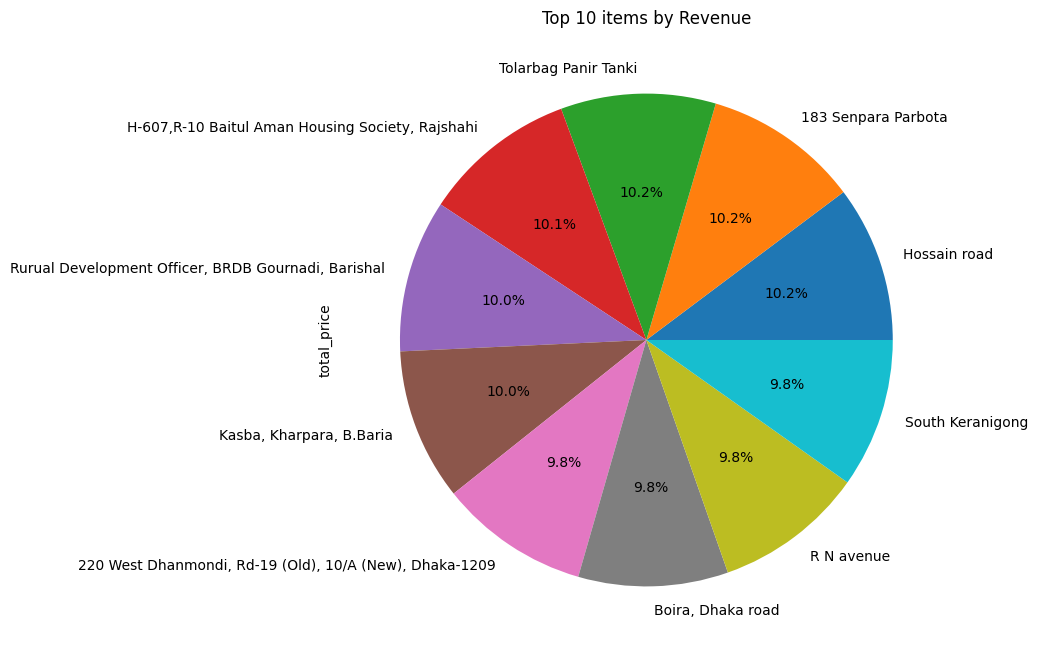

In [ ]:
store_revenue.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Top 10 items by Revenue')
plt.show()

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [ ]:
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')
customer_df = pd.read_excel('case-study-data.xlsx', sheet_name='Customer_dim')

In [ ]:
merged_df = fact_df.merge(customer_df, on='customer_key', how='left')
filtered_df = merged_df[merged_df['item_key'].isin(['I00152', 'I00184'])]

In [ ]:
customer_freq = filtered_df.groupby(['division', 'item_key'])['customer_key'].nunique().reset_index()
customer_freq.columns = ['division', 'item_key', 'unique_customers']

In [ ]:
budget = 1000
model = pulp.LpProblem("Promotion_Optimization", pulp.LpMaximize)
divisions = customer_freq['division'].unique()
promo = pulp.LpVariable.dicts("Promo", [(div, item) for div in divisions for item in ['I00152', 'I00184']],
                              lowBound=0, upBound=budget, cat='Continuous')

In [ ]:
model += pulp.lpSum([promo[(div, item)] * customer_freq[(customer_freq['division'] == div) &
                                                        (customer_freq['item_key'] == item)]['unique_customers'].iloc[0]
                     for div in divisions for item in ['I00152', 'I00184']])

In [ ]:
model += pulp.lpSum([promo[(div, item)] for div in divisions for item in ['I00152', 'I00184']]) <= budget

In [ ]:
model.solve()
optimized_promo = {(div, item): promo[(div, item)].value() for div in divisions for item in ['I00152', 'I00184']}
promo_df = pd.DataFrame([(div, item, val) for (div, item), val in optimized_promo.items()],
                        columns=['division', 'item_key', 'promo_budget'])
promo_df['unique_customers'] = promo_df.apply(
    lambda row: customer_freq[(customer_freq['division'] == row['division']) &
                             (customer_freq['item_key'] == row['item_key'])]['unique_customers'].iloc[0], axis=1)

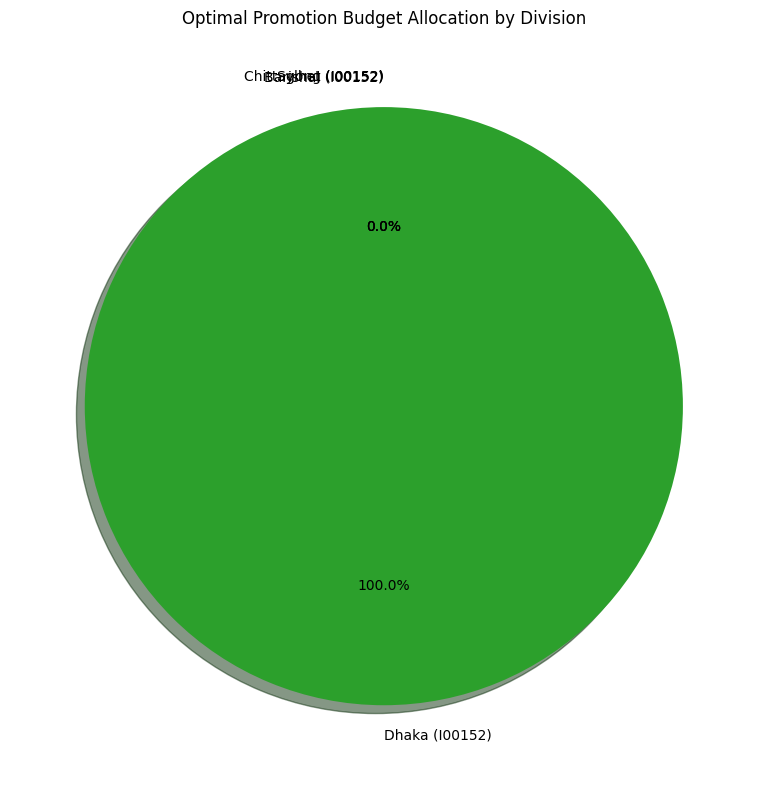

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8), dpi=100)

# Example: loop over specific item(s)
for item in ['I00152']:
    # Filter for selected item
    item_data = promo_df[promo_df['item_key'] == item]

    # Combine division name + item ID for labeling
    labels = item_data['division'] + ' (' + item + ')'
    sizes = item_data['promo_budget']

    # Pie chart for this item
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        shadow=True
    )

plt.title('Optimal Promotion Budget Allocation by Division')
plt.tight_layout()
plt.show()


In [ ]:
# Print
print("Optimized Promotion Budget Allocation:")
print(promo_df)
print(f"Total Budget Used: {sum(promo_df['promo_budget']):.2f} BDT")

Optimized Promotion Budget Allocation:
     division item_key  promo_budget  unique_customers
0    Barishal   I00152  0.000000e+00                 4
1    Barishal   I00184  0.000000e+00                14
2  Chittagong   I00152  0.000000e+00                22
3  Chittagong   I00184  0.000000e+00                26
4       Dhaka   I00152  1.023181e-12               160
5       Dhaka   I00184  1.000000e+03               280
6      Sylhet   I00152  0.000000e+00                 7
7      Sylhet   I00184  0.000000e+00                13
Total Budget Used: 1000.00 BDT


In [ ]:
promo_df.head(10)

,division,item_key,promo_budget,unique_customers
0,Barishal,I00152,0.000000e+00,4
1,Barishal,I00184,0.000000e+00,14
2,Chittagong,I00152,0.000000e+00,22
3,Chittagong,I00184,0.000000e+00,26
4,Dhaka,I00152,1.023181e-12,160
5,Dhaka,I00184,1.000000e+03,280
6,Sylhet,I00152,0.000000e+00,7
7,Sylhet,I00184,0.000000e+00,13


In [ ]:
new_promo_df=promo_df[['division','unique_customers']]
new_promo_df.head()

,division,unique_customers
0,Barishal,4
1,Barishal,14
2,Chittagong,22
3,Chittagong,26
4,Dhaka,160


In [ ]:
df = new_promo_df.groupby('division')['unique_customers'].sum().sort_values(ascending=False).head(10)
print("Top unique customers")
print(df)

Top unique customers
division
Dhaka         440
Chittagong     48
Sylhet         20
Barishal       18
Name: unique_customers, dtype: int64


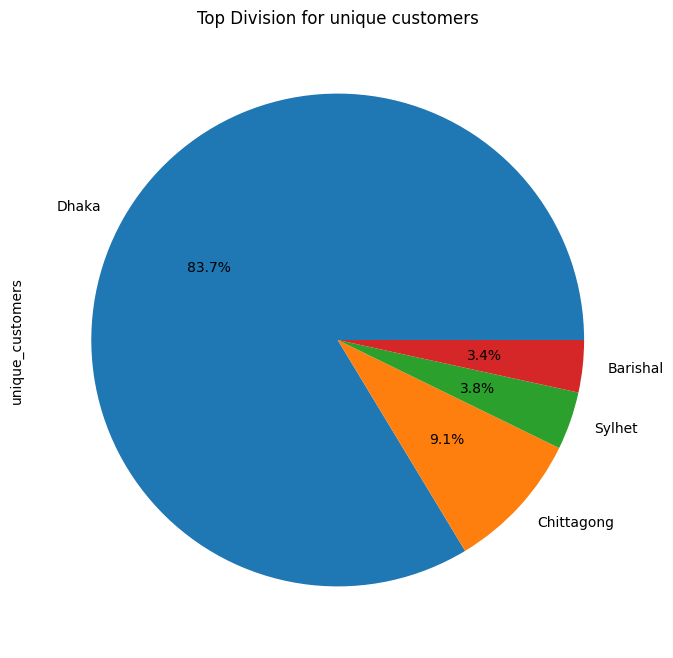

In [ ]:
df.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Top Division for unique customers')
plt.show()

In [ ]:
file_path = "case-study-data.xlsx"
fact     = pd.read_excel(file_path, sheet_name='Fact_table')
store    = pd.read_excel(file_path, sheet_name='Store_dim')

In [ ]:
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')

In [ ]:
S0035_rows = fact_df[fact_df['store_key'] == 'S0035']

In [ ]:
S0035_rows.head()

,payment_key,customer_key,time_key,item_key,store_key,quantity_sold,unit,unit_price,total_price
0,P025,C005440,T01562,I00264,S0035,1,Ct,15.00,15.0
79,P013,C004861,T04763,I00250,S0035,5,pack,19.50,97.5
108,P019,C001321,T01480,I00128,S0035,6,pk,16.00,96.0
196,P011,C001845,T03252,I00017,S0035,8,cans,6.75,54.0
204,P011,C005226,T03829,I00203,S0035,8,ct,18.00,144.0


In [ ]:
item_sales = S0035_rows.groupby('item_key')['quantity_sold'].sum().sort_values(ascending=False).head(10)

In [ ]:
# Group by item_key and calculate total price earned
item_revenue = S0035_rows.groupby('item_name')['total_price'].sum().sort_values(ascending=False).head(10)

In [ ]:
item_sales.head(5)

,quantity_sold
item_key,
I00264,574
I00263,472
I00120,405
I00121,348
I00131,291


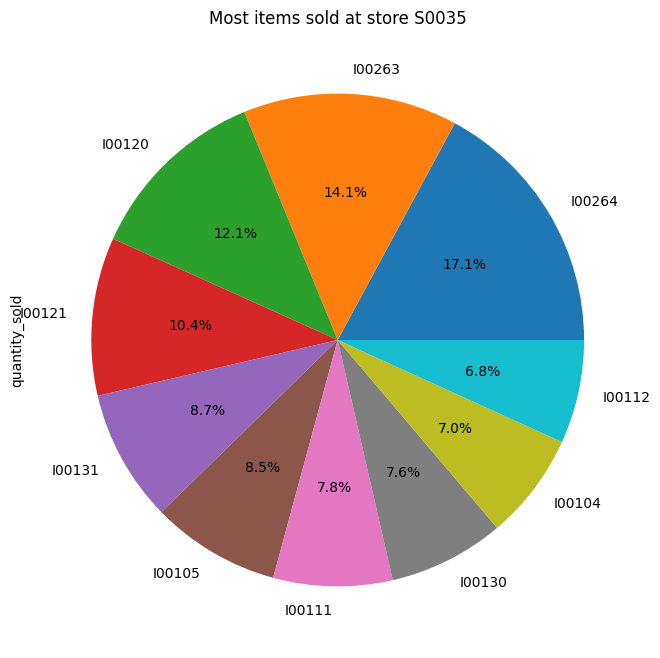

In [ ]:
item_sales.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Most items sold at store S0035')
plt.show()

In [ ]:
import pandas as pd

# Read the Excel file
file_path = "case-study-data.xlsx"
fact     = pd.read_excel(file_path, sheet_name='Fact_table')
store    = pd.read_excel(file_path, sheet_name='Store_dim')

# Compute correlation with column 'a'
correlation_with_a = fact.corr(numeric_only=True)['item_key'].sort_values(ascending=False)

# Display the result
print("Correlation of each column with Item_key:")
print(correlation_with_a)

KeyError: 'item_key'

In [ ]:
import pandas as pd

# Load your uploaded Excel file
df = pd.read_excel("case-study-data.xlsx")

# Show column names to check what’s available
print("Columns in dataset:")
print(df.columns)

# Compute correlation matrix (only numeric columns)
corr_matrix = df.corr(numeric_only=True)

# Display the full correlation matrix
print("\nCorrelation Matrix:")
print(corr_matrix)

# Example: correlation of all columns with 'quantity_sold'
if 'quantity_sold' in df.columns:
    correlation_with_quantity = corr_matrix['quantity_sold'].sort_values(ascending=False)
    print("\nCorrelation with 'quantity_sold':")
    print(correlation_with_quantity)
else:
    print("\nColumn 'quantity_sold' not found in dataset.")


Columns in dataset:
Index(['payment_key', 'customer_key', 'time_key', 'item_key', 'store_key',
       'quantity_sold', 'unit', 'unit_price', 'total_price'],
      dtype='object')

Correlation Matrix:
               quantity_sold  unit_price  total_price
quantity_sold       1.000000   -0.000910     0.726609
unit_price         -0.000910    1.000000     0.607086
total_price         0.726609    0.607086     1.000000

Correlation with 'quantity_sold':
quantity_sold    1.000000
total_price      0.726609
unit_price      -0.000910
Name: quantity_sold, dtype: float64


Correlation Matrix (including encoded string columns):
               payment_key  customer_key  time_key  item_key  store_key  \
payment_key       1.000000      0.000977 -0.003814  0.002307  -0.001398   
customer_key      0.000977      1.000000  0.001078  0.002888  -0.001762   
time_key         -0.003814      0.001078  1.000000  0.002122  -0.003604   
item_key          0.002307      0.002888  0.002122  1.000000   0.006135   
store_key        -0.001398     -0.001762 -0.003604  0.006135   1.000000   
quantity_sold     0.000329     -0.000901  0.002646  0.003065  -0.003420   
unit              0.005695      0.003228 -0.005529  0.141230   0.004225   
unit_price        0.001587     -0.005706  0.000295 -0.089521  -0.004709   
total_price       0.001531     -0.004506  0.003034 -0.053225  -0.005112   

               quantity_sold      unit  unit_price  total_price  
payment_key         0.000329  0.005695    0.001587     0.001531  
customer_key       -0.000901  0.003228   -0.005706    -0.00450

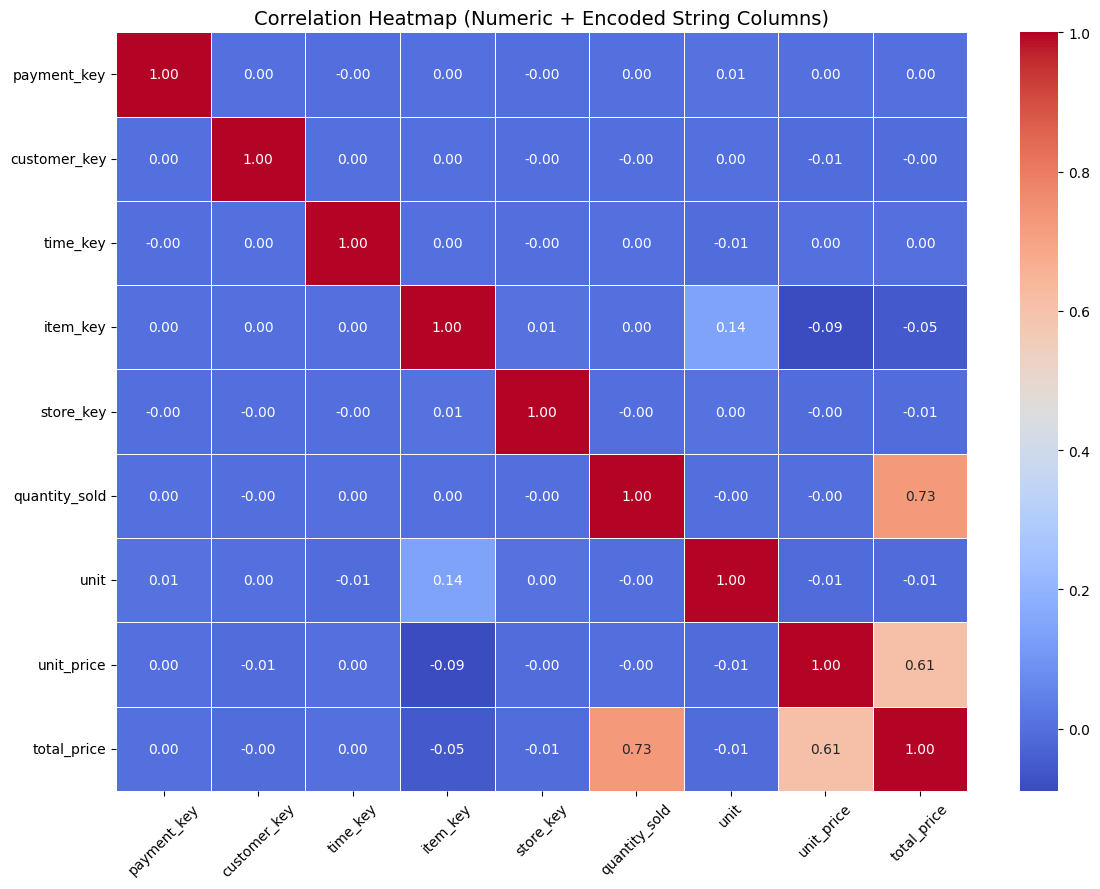

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load your Excel file
df = pd.read_excel("case-study-data.xlsx")

# Make a copy to avoid altering original data
df_encoded = df.copy()

# Encode string/categorical columns into numeric codes
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Compute correlation matrix (now includes previously string columns)
corr_matrix = df_encoded.corr(numeric_only=True)

# Display correlation matrix
print("Correlation Matrix (including encoded string columns):")
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric + Encoded String Columns)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt

# Step 1: Load data directly from Excel file (replace 'case-study-data.xlsx' with your file path)
fact_df = pd.read_excel('case-study-data.xlsx', sheet_name='Fact_table')

# Step 2: Filter for store_key 'S0035'
s0035_df = fact_df[fact_df['store_key'] == 'S0035']

# Step 3: Group by item_key to calculate total quantity_sold, total_price, and average unit_price
item_summary = s0035_df.groupby('item_key').agg({
    'quantity_sold': 'sum',
    'total_price': 'sum',
    'unit_price': 'mean'
}).reset_index()

# Step 4: Prescriptive Optimization (Linear Programming with PuLP)
def optimize_inventory(item_df, total_units=100):
    items = item_df['item_key'].tolist()
    revenue = dict(zip(items, item_df['unit_price']))  # Average revenue per unit

    # Set up PuLP model
    model = pulp.LpProblem("Inventory_Allocation", pulp.LpMaximize)
    units = pulp.LpVariable.dicts("Units", items, lowBound=0, cat='Integer')  # Decision variables

    # Objective: Maximize revenue
    model += pulp.lpSum([units[item] * revenue[item] for item in items])

    # Constraint: Total units ≤ total_units
    model += pulp.lpSum([units[item] for item in items]) <= total_units

    # Solve
    model.solve()

    # Optimized allocation
    optimized = {item: units[item].value() for item in items}
    optimized_df = pd.DataFrame(list(optimized.items()), columns=['item_key', 'optimal_units'])
    optimized_df['projected_revenue'] = optimized_df['optimal_units'] * [revenue[item] for item in optimized_df['item_key']]
    total_revenue = optimized_df['projected_revenue'].sum()
    return optimized_df, total_revenue

# Run optimization
optimized_df, total_revenue = optimize_inventory(item_summary)


# Step 6: Print Optimized Summary
print("Optimized Inventory Allocation for Store S0035:")
print(optimized_df)
print(f"Total Projected Revenue: {total_revenue:.2f} BDT")

Optimized Inventory Allocation for Store S0035:
    item_key  optimal_units  projected_revenue
0     I00001            0.0                0.0
1     I00002            0.0                0.0
2     I00003            0.0                0.0
3     I00005            0.0                0.0
4     I00006            0.0                0.0
..       ...            ...                ...
256   I00260            0.0                0.0
257   I00261            0.0                0.0
258   I00262            0.0                0.0
259   I00263            0.0                0.0
260   I00264            0.0                0.0

[261 rows x 3 columns]
Total Projected Revenue: 5500.00 BDT


In [ ]:
optimized_df.head(10)

,item_key,optimal_units,projected_revenue
0,I00001,0.0,0.0
1,I00002,0.0,0.0
2,I00003,0.0,0.0
3,I00005,0.0,0.0
4,I00006,0.0,0.0
5,I00007,0.0,0.0
6,I00008,0.0,0.0
7,I00009,0.0,0.0
8,I00010,0.0,0.0
9,I00011,0.0,0.0


In [ ]:
optimized_df.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Most items sold at store S0035')
plt.show()

ValueError: pie requires either y column or 'subplots=True'

/tmp/ipython-input-354609976.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_df['quantity_sold'] = pd.to_numeric(item_df['quantity_sold'], errors='coerce')
/tmp/ipython-input-354609976.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_df['unit_price'] = pd.to_numeric(item_df['unit_price'], errors='coerce')
/tmp/ipython-input-354609976.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

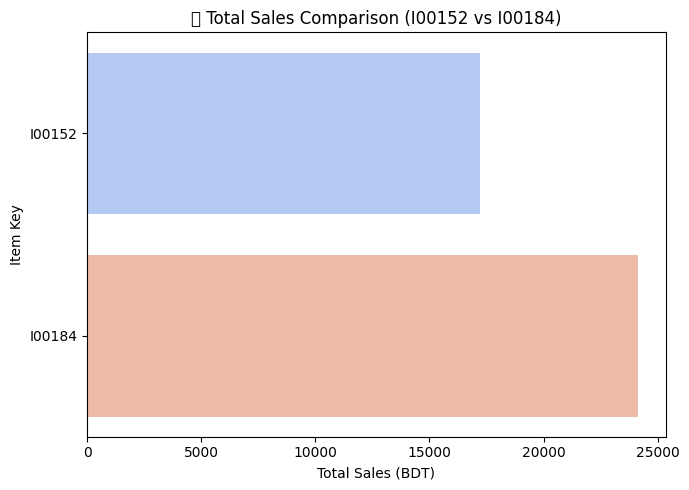

/tmp/ipython-input-354609976.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price, x='unit_price', y='item_key', palette='mako')
/tmp/ipython-input-354609976.py:37: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


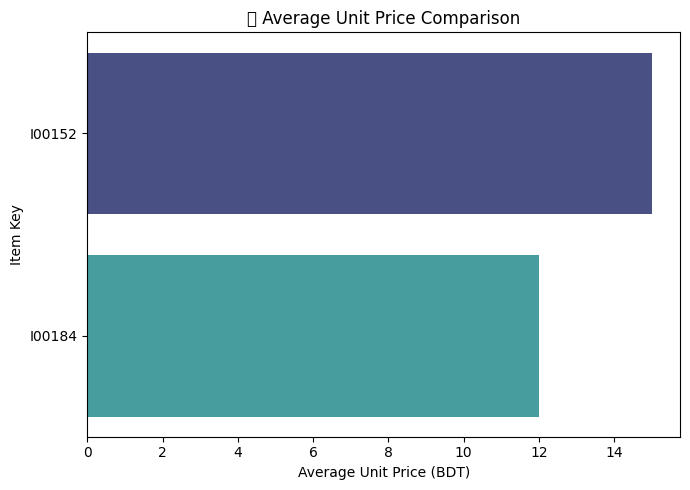

/tmp/ipython-input-354609976.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=item_df, x='item_key', y='quantity_sold', palette='Set2')
/tmp/ipython-input-354609976.py:46: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


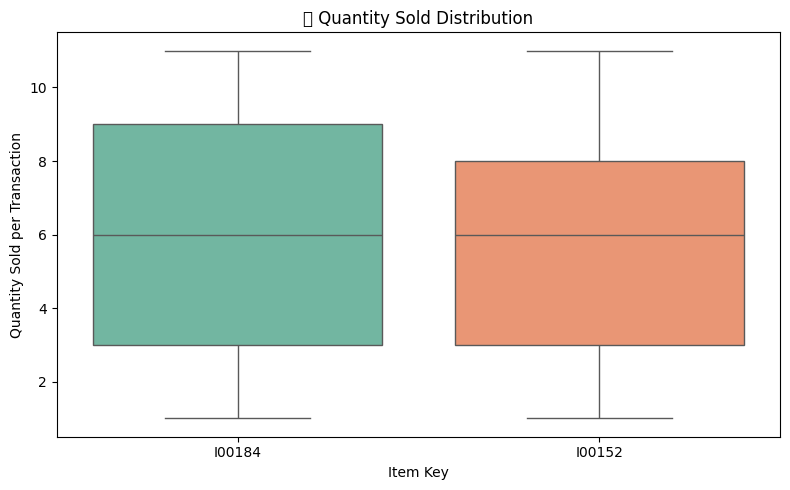

/tmp/ipython-input-354609976.py:58: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127978 (\N{CONVENIENCE STORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


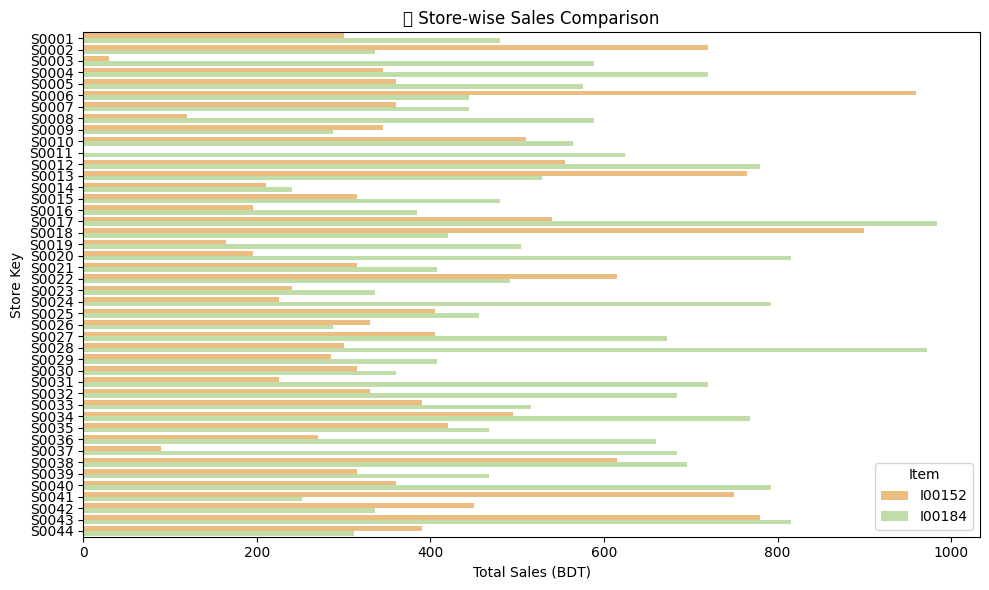

/tmp/ipython-input-354609976.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


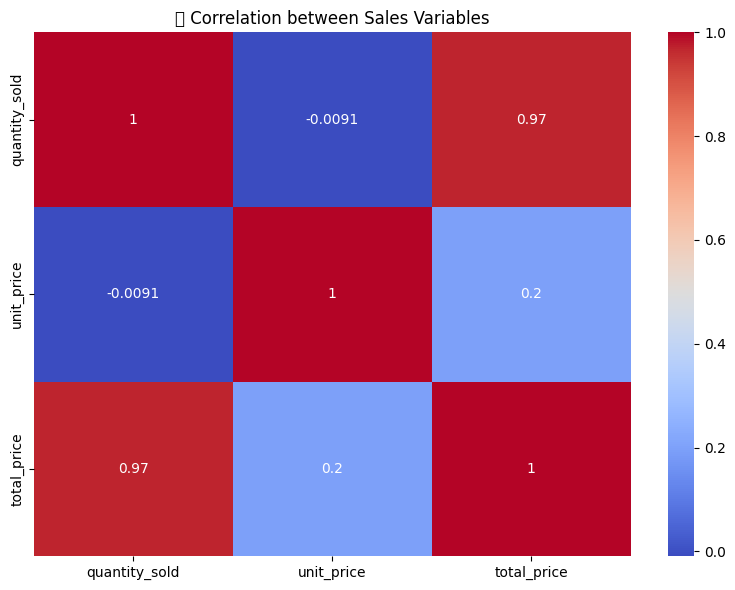

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
file_path = "case-study-data.xlsx"
df = pd.read_excel(file_path)

# Filter for the two items
items = ['I00152', 'I00184']
item_df = df[df['item_key'].isin(items)]

# Convert quantity and price to numeric (if needed)
item_df['quantity_sold'] = pd.to_numeric(item_df['quantity_sold'], errors='coerce')
item_df['unit_price'] = pd.to_numeric(item_df['unit_price'], errors='coerce')
item_df['total_price'] = pd.to_numeric(item_df['total_price'], errors='coerce')

# 1️⃣ Total Sales Comparison
sales_summary = item_df.groupby('item_key')['total_price'].sum().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=sales_summary, x='total_price', y='item_key', palette='coolwarm')
plt.title("💰 Total Sales Comparison (I00152 vs I00184)")
plt.xlabel("Total Sales (BDT)")
plt.ylabel("Item Key")
plt.tight_layout()
plt.show()

# 2️⃣ Average Unit Price Comparison
avg_price = item_df.groupby('item_key')['unit_price'].mean().reset_index()

plt.figure(figsize=(7,5))
sns.barplot(data=avg_price, x='unit_price', y='item_key', palette='mako')
plt.title("🏷️ Average Unit Price Comparison")
plt.xlabel("Average Unit Price (BDT)")
plt.ylabel("Item Key")
plt.tight_layout()
plt.show()

# 3️⃣ Quantity Distribution
plt.figure(figsize=(8,5))
sns.boxplot(data=item_df, x='item_key', y='quantity_sold', palette='Set2')
plt.title("📦 Quantity Sold Distribution")
plt.xlabel("Item Key")
plt.ylabel("Quantity Sold per Transaction")
plt.tight_layout()
plt.show()

# 4️⃣ Store-wise Total Sales
store_sales = item_df.groupby(['store_key', 'item_key'])['total_price'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=store_sales, x='total_price', y='store_key', hue='item_key', palette='Spectral')
plt.title("🏪 Store-wise Sales Comparison")
plt.xlabel("Total Sales (BDT)")
plt.ylabel("Store Key")
plt.legend(title='Item')
plt.tight_layout()
plt.show()

# 5️⃣ Correlation Heatmap (for numeric insight)
plt.figure(figsize=(8,6))
sns.heatmap(item_df[['quantity_sold','unit_price','total_price']].corr(), annot=True, cmap='coolwarm')
plt.title("📈 Correlation between Sales Variables")
plt.tight_layout()
plt.show()
